# Prepare data input for Amazon Forecast

> *This notebook should work with either the `Python 3 (Data Science)` kernel in SageMaker Studio, or `conda_python3` in classic SageMaker Notebook Instances*

Forecasting is used in a variety of applications and business use cases: For example, retailers need to forecast the sales of their products to decide how much stock they need by location, Manufacturers need to estimate the number of parts required at their factories to optimize their supply chain, Businesses need to estimate their flexible workforce needs, Utilities need to forecast electricity consumption needs in order to attain an efficient energy network, and enterprises need to estimate their cloud infrastructure needs.
<img src="https://amazon-forecast-samples.s3-us-west-2.amazonaws.com/common/images/forecast_overview.png" width="98%">

# Notebook Overview

This notebook provides a template of typical steps required to prepare data input for Amazon Forecast. So, this is part of "Upload your data to Amazon Forecast" in the diagram above.  Your data may need additional Prepare steps and/or you may not need all the steps in this notebook.<br>

You will need lots of customization in the RTS section.  Otherwise, look for following comment string to indicate places you will need to customize this notebook for your data:

In [1]:
####
# EDIT THIS FOR YOUR DATA
####

<b>Step 1 Read data</b>. Modify this section to read your data.

<b>Step 2 Make forecast choices</b>. You need to make some decisions.  How many time units in future do you want to make forecasts?  E.g. if time unit is Hour, then if you want to forecast out 1 week that would be 24*7 = 168 hours.  You'll also be asked if you want integer or float target_values.  And if 0's really mean 0 or are they missing data?

<b>Step 10 Aggregate based on the time granularity of your data.</b> Possible aggregations are minute, hour, day, week, month.  See <a href="https://docs.aws.amazon.com/forecast/latest/dg/howitworks-datasets-groups.html#howitworks-data-alignment" target="_blank">documenatation. </a>

<b>Step 12 Visualization time series and validate the time granularity you chose makes sense.</b>  Too low-granularity means the time series looks like white noise and the data could benefit by aggregation at higher-time-level.  For example, you might start to notice time series cyclical patterns when aggregating historical sales by-hour instead of of by-minute.  Alternate between Step 7 Visualization and Step 5 Aggregation until you are happy with the chosen time-grandularity for your forecasts.

<b>Steps 10 (Aggregate) and 13 (Split train) include a set of common checks on your data for forecasting.</b> One common mistake is customers think they should "try Amazon Forecast with a small sample of data".  If the majority of your time series have fewer than 300 data points, Amazon Forecast will fail, because Amazon Forecast is designed for deep-learning AI forecasting algorithms, which require many data points (typically 1000+) per time series.  Small data is better off using traditional, open-source forecast methods such as ETS (available in Excel), ARIMA, or Prophet.  Small data is not a good fit for Amazon Forecast.  If you really want to try Amazon Forecast, but your data fails the Error Checks consider: 

<ul>
    <li>Can you get more data such that each time series will have longer history with more data points?  If so, return to Step 1.</li>
    <li>Can you combine items into fewer item_ids such that each time series will have longer history with more data points?  If so, return to Step 1.</li>
    <li>Can you reduce forecast dimensions, such as use item_id only and drop location_id?  If so, return to Step 5.</li>
    <li>Can you drop to a lower time-frequency without your data turning into white noise?  Check your data again using Step 10 Aggregate and Step 12 Visualize. </li>
</ul>
 
It may be that you find your data is not a good fit for Amazon Forecast.  In that case, it's better that you discover this early.

<b>In steps 14-20, we will save headerless Target Time Series (TTS), Item metadata (IM), Related Time Series (RTS) to S3</b> so we can trigger Amazon Forecast automation, see
    <a href="https://github.com/aws-samples/amazon-forecast-samples/blob/master/workshops/pre_POC_workshop/install-forecast-solution.md" target="_blank">Workshop Instructions Install Automation and Demo</a>

TODO:  bucket steps so list doesn't look so long! <br>
TODO:  Add data normalization step

# Table of Contents 
* Step 0: [Set up and install libraries](#setup)
* Step 1: [Read data](#read)
* Step 2: [Correct dtypes](#fix_dtypes)
* Step 3: [Make forecast choices](#choices)
* Step 4: [Drop null item_ids](#drop_null_items)
* Step 5: [Drop null timestamps](#drop_null_times) 
* Step 7: [Inspect and treat extremes](#treat_extremes) 
* Step 8: [Optional - Round negative targets up to 0](#round_negatives) 
* Step 9: [Optional - Convert negative targets to_nan](#negatives_to_nan) 
* Step 10: [Aggregate at chosen frequency](#groupby_frequency) 
* Step 11: [Typical Retail scenario: Find top-moving items](#top_moving_items)
* Step 12: [Visualize time series](#visualize) 
* Step 13: [Split train/test data](#split_train_test)
* Step 14: [Prepare and save Target Time Series](#TTS) 
* Step 15: [Remove time series with no target values at all](#TTS_remove_all0)
* Step 16: [Remove time series with end of life](#TTS_remove_end_of_life)
* Step 17: [Remove time series with fewer than 5 data points](#TTS_remove_too_few_data_points)
* Step 18: [Optional - Assemble and save TTS_sparse, TTS_dense](#TTS-dense_sparse)
* Step 19: [Optional - Assemble and save TTS_top, TTS_slow](#TTS_top)
* Step 20: [Assemble and save RTS (if any)](#RTS)
* Step 21: [Classify time series](#Classify)
* Step 22: [Optional - Assemble and save TTS_smooth, TTS_erratic, TTS_intermittent, TTS_lumpy](#TTS_classes)
* Step 23: [Assemble and save metadata (if any)](#IM) 

## Data used in these notebooks: NYC Taxi trips open data

Given hourly historical taxi trips data for NYC, your task is to predict #pickups in next 7 days, per hour and per pickup zone.  <br>

<ul>
<li>Original data source:  <a href="https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page" target="_blank"> https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page</a> </li>
<li>AWS-hosted public source:  <a href="https://registry.opendata.aws/nyc-tlc-trip-records-pds/" target="_blank">https://registry.opendata.aws/nyc-tlc-trip-records-pds/ </a> </li>
<li>AWS managed weather data ingestion as a service that is bundled with Amazon Forecast, aggregated by location and by hour.  Initially only for USA and Europe, but depending on demand, possibly in the future for other global regions. </li>
<li>Data used:  Yellow taxis dates: 2018-12 through 2020-02 to avoid COVID effects </li>
</ul>

 
### Features and cleaning
Note: ~5GB Raw Data has already been cleaned and joined using AWS Glue (tutorials to be created in future). 
<ul>
    <li>Join shape files Latitude, Longitude</li>
    <li>Add Trip duration in minutes</li>
    <li>Drop negative trip distances, 0 fares, 0 passengers, less than 1min trip durations </li>
    <li>Drop 2 unknown zones ['264', '265']
    </ul>

## Step 0:  Set up and install libraries <a class="anchor" id="setup"></a>

This notebook will use a range of Python's built-in modules, some open source libraries from AWS and third parties, and some local 'utility' modules where we've packaged some common functions to help keep the notebook concise.

If you'd like to dive deeper, you'll be able to find the source code for all referenced `util` and `local_util` functions in this code repository.

In [2]:
# Optionally install dask for faster joins when df is large
!pip install "dask[dataframe]"

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
%load_ext autoreload
%autoreload 2

# Python standard built-ins:
import datetime
import os
import random
import sys
import time

# Open-source libraries:
import boto3  # The AWS SDK for Python
from dateutil.relativedelta import relativedelta
import matplotlib as mpl  # Graph plotting
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np  # Numerical processing
import pandas as pd  # Dataframe (tabular data) processing
import seaborn as sns  # Graph plotting

print('matplotlib: {}'.format(mpl.__version__))
print('numpy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('seaborn: {}'.format(sns.__version__))

# Local code:
import local_util  # From the local_util/ folder
sys.path.insert( 0, os.path.abspath("../../notebooks/common") )
import util  # From this repository's /notebooks/common folder

matplotlib: 3.3.4
numpy: 1.19.5
pandas: 1.1.5
seaborn: 0.11.1


Here we'll perform some initial display configuration and choose a color palette, for later visualizations:

In [4]:
np.random.seed(42)  # Seed random number generator for consistent results

local_util.plotting.configure_pandas_display()

color_pal = sns.color_palette("colorblind", 6).as_hex()
colorblind6 = ','.join(color_pal).split(",")

<b>Create a new S3 bucket for this lesson</b>
- The cell below will create a new S3 bucket with name ending in "forecast-demo-taxi"

In [5]:
# create unique S3 bucket for saving your own data

####
# EDIT THIS FOR YOUR DATA
####
region = boto3.Session("s3").region_name
print(f"region = {region}")
account_id = boto3.client('sts').get_caller_identity().get('Account')

# create unique S3 bucket for saving your own data
bucket_name = account_id + '-forecast-demo-taxi'
print(f"bucket_name = {bucket_name}")
util.create_bucket(bucket_name, region)
    
# create prefix for organizing your new bucket
prefix = "nyc-taxi-trips"
print(f"using folder '{prefix}'")

# ...and a folder for local files
os.makedirs("data", exist_ok=True)

region = us-east-1
bucket_name = 674465894274-forecast-demo-taxi
An error occurred (IllegalLocationConstraintException) when calling the CreateBucket operation: The unspecified location constraint is incompatible for the region specific endpoint this request was sent to.
using folder 'nyc-taxi-trips'


In [6]:
# Connect API sessions
session = boto3.Session(region_name=region) 
s3 = session.client(service_name='s3')
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

In [7]:
# check you can communicate with Forecast APIs
forecast.list_predictors()

{'Predictors': [{'PredictorArn': 'arn:aws:forecast:us-east-1:674465894274:predictor/AmazonForecastWorkshopPredictor1',
   'PredictorName': 'AmazonForecastWorkshopPredictor1',
   'DatasetGroupArn': 'arn:aws:forecast:us-east-1:674465894274:dataset-group/AmazonForecastWorkshopDatasetGroup',
   'Status': 'ACTIVE',
   'CreationTime': datetime.datetime(2021, 5, 11, 16, 6, 50, 392000, tzinfo=tzlocal()),
   'LastModificationTime': datetime.datetime(2021, 5, 12, 16, 1, 2, 591000, tzinfo=tzlocal())}],
 'ResponseMetadata': {'RequestId': 'cfb6750d-0856-4c3a-bf24-c1e326e3bdd4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 15 Nov 2021 18:51:49 GMT',
   'x-amzn-requestid': 'cfb6750d-0856-4c3a-bf24-c1e326e3bdd4',
   'content-length': '392',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

<b>Create IAM Role for Forecast</b> <br>
Like many AWS services, Forecast will need to assume an IAM role in order to interact with your S3 resources securely. In the sample notebooks, we use the get_or_create_iam_role() utility function to create an IAM role. Please refer to "notebooks/common/util/fcst_utils.py" for implementation.

In [8]:
# check sagemaker session first, if not found create a role
try:
    from sagemaker import get_execution_role
    role_arn = get_execution_role()
except:
    # Create the role to provide to Amazon Forecast.
    role_name = "ForecastNotebookRole-Basic"
    print(f"Creating Role {role_name} ...")
    role_arn = util.get_or_create_iam_role( role_name = role_name )
    
# echo user inputs without account
print(f"Success! Using role arn = {role_arn.partition('/')[2]}")

Success! Using role arn = translate-demo-role


## Step 1. Read data <a class="anchor" id="read"></a>

The first thing we're going to do is read the headerless .csv file.  Then we need to identify which columns map to required Amazon Forecast inputs.

<img src="https://amazon-forecast-samples.s3-us-west-2.amazonaws.com/common/images/nyctaxi_map_fields.png" width="82%">
<br>

<b>In order to use Weather Index, you need a geolocation-type column.</b>  The geolocation-type column connects your locations to geolocations, and can be 5-digit postal code or latitude_longitude.  For more details, see:
<ul>
    <li><a href="https://docs.aws.amazon.com/forecast/latest/dg/weather.html" target="_blank">Link to documentation about geolocations</a></li>
    <li><a href="https://aws.amazon.com/blogs/machine-learning/amazon-forecast-weather-index-automatically-include-local-weather-to-increase-your-forecasting-model-accuracy/" target="_blank">Our Weather blog, which shows UI steps.</a></li>
</ul>

The cell below shows an example reading headerless csv file with lat_lon geolocation column, "pickup_geolocation".  The rest of this notebook writes headerless csv files to be able to use automation.  If you are not planning on using the automation solution, .csv files with headers are allowed.

In [9]:
####
# EDIT THIS FOR YOUR DATA
####

## Read cleaned, joined, featurized data from Glue ETL processing
df_raw = pd.read_csv(
    "s3://amazon-forecast-samples/data_prep_templates/clean_features.csv",
    parse_dates=True,
    header=None,
    dtype={
        0: "str",
        1: "str",
        2: "str",
        3: "str",
        4: "int32",
        5: "float64",
        6: "str",
        7: "str",
        8: "str",
    },
    names=[
        "pulocationid", "pickup_hourly", "pickup_day_of_week", "day_hour", "trip_quantity",
        "mean_item_loc_weekday", "pickup_geolocation", "pickup_borough", "binned_max_item",
    ],
)

# drop duplicates
print(df_raw.shape)
df_raw.drop_duplicates(inplace=True)

df_raw['pickup_hourly'] = pd.to_datetime(df_raw["pickup_hourly"], format="%Y-%m-%d %H:%M:%S", errors='coerce')
print(df_raw.shape)
print(df_raw.dtypes)
start_time = df_raw.pickup_hourly.min()
end_time = df_raw.pickup_hourly.max()
print(f"Min timestamp = {start_time}")
print(f"Max timestamp = {end_time}")
df_raw.sample(5)

(1507488, 9)
(1507488, 9)
pulocationid                     object
pickup_hourly            datetime64[ns]
pickup_day_of_week               object
day_hour                         object
trip_quantity                     int32
mean_item_loc_weekday           float64
pickup_geolocation               object
pickup_borough                   object
binned_max_item                  object
dtype: object
Min timestamp = 2019-07-01 00:00:00
Max timestamp = 2020-02-29 23:00:00


,pulocationid,pickup_hourly,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
1316173,193,2020-02-07 19:00:00,Friday,Friday_19,1,3.66712,40.76172443_-73.9402863,Queens,Cat_1
883169,199,2019-12-25 19:00:00,Wednesday,Wednesday_19,0,1.00000,40.79204594_-73.8835364,Bronx,Cat_1
1270212,22,2019-12-29 09:00:00,Sunday,Sunday_9,0,1.03061,40.60962734_-73.99429702,Brooklyn,Cat_1
1425067,120,2019-08-13 09:00:00,Tuesday,Tuesday_9,0,1.06250,40.84600407_-73.93080685,Manhattan,Cat_1
736958,206,2019-09-16 12:00:00,Monday,Monday_12,0,1.00000,40.6359594_-74.12316376,Staten Island,Cat_1


In [10]:
####
# EDIT THIS FOR YOUR DATA
####

# map expected column names
item_id = "pulocationid"
target_value = "trip_quantity"
timestamp = "pickup_hourly"
location_id = None
geolocation = "pickup_geolocation"

if location_id is None:
    use_location = False
else:
    use_location = True
print(f"use_location = {use_location}")

# specify array of dimensions you'll use for forecasting
if use_location:
    forecast_dims = [timestamp, location_id, item_id]
else:
    forecast_dims = [timestamp, item_id]
print(f"forecast_dims = {forecast_dims}")
dims_except_timestamp = [i for i in forecast_dims if i != timestamp]
print(f"dims_except_timestamp = {dims_except_timestamp}")

use_location = False
forecast_dims = ['pickup_hourly', 'pulocationid']
dims_except_timestamp = ['pulocationid']


In [11]:
original_shape = df_raw.shape 
original_shape

(1507488, 9)

## Step 2. Correct dtypes <a class="anchor" id="fix_dtypes"></a>

In [12]:
####
# EDIT THIS FOR YOUR DATA
####
# # correct dtypes
# df_raw['ReportingMonth'] = pd.to_datetime(df_raw["ReportingMonth"], format="%Y-%m-%d", errors='coerce')
# # Use the new pandas Integer type
# df_raw.ProductGroup3Id = df_raw.ProductGroup3Id.astype('Int64').astype(str)
# # df_raw.ProductGroup3Id = df_raw.ProductGroup3Id.astype('Int64')
print(df_raw.shape)
print(df_raw.dtypes)

# df_raw.sample(5)

(1507488, 9)
pulocationid                     object
pickup_hourly            datetime64[ns]
pickup_day_of_week               object
day_hour                         object
trip_quantity                     int32
mean_item_loc_weekday           float64
pickup_geolocation               object
pickup_borough                   object
binned_max_item                  object
dtype: object


## Step 3. Make forecast choices <a class="anchor" id="choices"></a>

Below, you need to make some choices.  First, you will be asked how you want to treat target values (the values you're forecasting). 
<ol>
    <li><b>Do you want your target values to be floating point numbers or integers? Pro-tip: If your raw data values are already integers or if you need to forecast new items/cold-starts, leave this setting as 'False' to do nothing; otherwise, best practice is set equal 'True'.</b>  If you have floating point numbers, you won't be able to use negative-binomial distribution later in the DeepAR+ algorithm. Setting 'False' will leave raw data values as they are. </li>
    <li><b>Decide if you want to convert 0's to nulls. Pro-tip:  Use setting 'True',</b> then let Amazon Forecast  <a href="https://docs.aws.amazon.com/forecast/latest/dg/howitworks-missing-values.html" target="_blank">do automatic null-filling through its Featurization settings.</a>. Setting 'True' will convert 0's to nulls. It means you think some of your 0's were missing data instead of actual 0's. Warning: if you have cold-starts, or new product introductions, they may get dropped. You will need to manually re-add them to only the Inference data, since they should be dropped from Train data.  However, if you believe in your data '0' always means '0', then type 'False' to do nothing to 0's. </li>
    <li><b>Decide if you want to replace extreme values with mean?</b>  If you think you only have one or two extreme values it might make sense to replace them. On the other hand, if you have quite a few, that is indication those values are not really extreme.</li>
    <li><b>Do you want to generate future RTS that extends into future?</b>  If you set this to True, all data will be used for Training.  If you set it to False, a hold-out of length Forecast Horizon will be used to alculte RTS.</li>
    <li><b>What is the time granularity for your forecasts?</b>. For example, if your time unit is Hour, answer = "H". </li>
    <li><b>How many time units do you want to forecast?</b>. For example, if your time unit is Hour, then if you want to forecast out 1 week, that would be 24*7 = 168 hours, so answer = 168. </li>
    <li><b>What is the first date you want to forecast?</b>  Training data will be cut short 1 time unit before the desired first forecast snapshot date.  For example, if the granularity of your data is "D" and you want your first forecast to happen on Feb 8, 2019, then the last timestamp for training will be Feb 7, 2019.</li>
    <li><b>Think of a name you want to give this experiment</b>, so all files will have the same names.  You should also use this same name for your Forecast DatasetGroup name, to set yourself up for reproducibility. </li>
    </ol>

In [13]:
# FORECAST SETTINGS
###################
# INSTRUCTIONS: 
# 1. replace occurences "xxx=+FORECAST_LENGTH" with correct dictionary value 
# 2. run this cell 1x, look at suggested "snapshot_date"
# 3. use suggested "snapshot_date", run again.
###################

# Round target values to integers
target_to_integer = False

# Replace 0's with nulls
replace_all_zeroes_with_null = False

# Replace extremes with mean of last 3 months
replace_extremes_with_mean = False

# Create RTS with unknown future data
# Note: if you set this to True, all known data will be used for Training
# Note: if you set this to False, a hold-out of length Forecast Horizon will be used to calculate RTS
create_future_RTS_with_unknown_data = False

# What is your forecast time unit granularity?
# Choices are: ^Y|M|W|D|H|30min|15min|10min|5min|1min$ 
FORECAST_FREQ = "H"

# what is your forecast horizon in number time units you've selected?
# e.g. if you're forecasting in hours, how many hours out do you want a forecast?
FORECAST_LENGTH = 168

# What is the first date you want to forecast? 
# Training data will be cut short 1 time unit before the desired first forecast snapshot date
# get snapshot date (date of 1st forecast) as last time minus forecast horizon
AF_freq_to_dateutil_freq = {"Y":"years", "M":"hours", "W":"weeks", "D":"days", "H":"hours"}

####
# EDIT THIS FOR YOUR DATA
####
###################
# INSTRUCTIONS: replace "xxx=FORECAST_LENGTH" with correct dictionary value from above
#               example if FORECAST_FREQ="W" then use "weeks=FORECAST_LENGTH"
###################
end_time_train = df_raw[timestamp].max() - relativedelta(hours=FORECAST_LENGTH)
snapshot_date = end_time_train.date() + relativedelta(days=1)
print(f"Suggested snapshot date = {snapshot_date}")

# Run entire cell 1x, to view the "Suggested snapshot date"
# Change snapshot date below to match suggested
SNAPSHOT_DATE = datetime.datetime(2020, 2, 23, 0, 0, 0)  

# What name do you want to give this experiment?  
# Be sure to use same name for your Forecast Dataset Group name.
EXPERIMENT_NAME = "nyctaxi"
DATA_VERSION = 1

# print some validation back to user
print(f"Convert your frequency to python dateutil = {AF_freq_to_dateutil_freq[FORECAST_FREQ]}")
print(f"Forecast horizon = {FORECAST_LENGTH} {AF_freq_to_dateutil_freq[FORECAST_FREQ]}")

AF_freq_to_dateutil_freq = {"Y":"years", "M":"hours", "W":"weeks", "D":"days", "H":"hours"}
####
# EDIT THIS FOR YOUR DATA
####
###################
# INSTRUCTIONS: replace "xxx=+FORECAST_LENGTH" with correct dictionary value from above
#               example if FORECAST_FREQ="W" then use "weeks=+FORECAST_LENGTH"
###################
snapshot_end = SNAPSHOT_DATE + relativedelta(hours=+FORECAST_LENGTH)
snapshot_end = snapshot_end - relativedelta(hours=1)
print(f"Training data end date = {end_time_train}")
print(f"Forecast start date = {SNAPSHOT_DATE}")
print(f"Forecast end date = {snapshot_end}")
start_time = df_raw[timestamp].min()
end_time = snapshot_end

snapshot_date_monthYear = SNAPSHOT_DATE.strftime("%m%d%Y")
EXPERIMENT_NAME = f"{EXPERIMENT_NAME}_snap{snapshot_date_monthYear}_{FORECAST_LENGTH}{FORECAST_FREQ}"
print(f"Experiment name = {EXPERIMENT_NAME}")

Suggested snapshot date = 2020-02-23
Convert your frequency to python dateutil = hours
Forecast horizon = 168 hours
Training data end date = 2020-02-22 23:00:00
Forecast start date = 2020-02-23 00:00:00
Forecast end date = 2020-02-29 23:00:00
Experiment name = nyctaxi_snap02232020_168H


## Step 4. Drop null item_ids <a class="anchor" id="drop_null_items"></a>

In [14]:
templist = df_raw[item_id].unique()
print(f"Number unique items: {len(templist)}")
print(f"Number nulls: {pd.isnull(templist).sum()}")

if len(templist) < 20:
    print(templist)

Number unique items: 260
Number nulls: 0


In [15]:
## Drop the null item_ids, if any exist
if pd.isnull(templist).sum() > 0:
    print(df_raw.shape)
    df_raw = df_raw.loc[(~df_raw[item_id].isna()), :].copy()
    print(df_raw.shape)
    print(len(df_raw[item_id].unique()))
else:
    print("No missing item_ids found.")

No missing item_ids found.


## Step 5. Drop null timestamps <a class="anchor" id="drop_null_times"></a>

In [16]:
# check null timestamps
templist = df_raw.loc[(df_raw[timestamp].isna()), :].shape[0]
print(f"Number nulls: {templist}")

if (templist < 10) & (templist > 0) :
    print(df_raw.loc[(df_raw[timestamp].isna()), :])

Number nulls: 0


In [17]:
## Drop the null quantities and dates
if templist > 0:
    print(df_raw.shape)
    df_raw = df_raw.loc[(~df_raw[timestamp].isna()), :].copy()
    print(df_raw.shape)
    print(df_raw['timestamp'].isna().sum())
else:
    print("No null timestamps found.")

No null timestamps found.


## Step 7. Inspect (and treat) extremes <a class="anchor" id="treat_extremes"></a>

In [18]:
# Decide how many extreme values is considered unusual
MAX_EXTREMES = 10
EXTREME_VALUE = df_raw[target_value].quantile(0.999999)
print(EXTREME_VALUE)

1533.394524011761


In [19]:
# Inspect extremes
templist = df_raw.loc[(df_raw[target_value]>=EXTREME_VALUE), :].shape[0]
print(f"Number extremes: {templist}")

if (templist < MAX_EXTREMES) & (templist > 0) :
    print(df_raw.loc[(df_raw[target_value]>=EXTREME_VALUE), :].set_index([item_id]))


Number extremes: 2
                   pickup_hourly pickup_day_of_week  day_hour  trip_quantity  mean_item_loc_weekday        pickup_geolocation pickup_borough binned_max_item
pulocationid                                                                                                                                                
79           2019-11-03 01:00:00             Sunday  Sunday_1           2085              288.91544  40.72794428_-73.98521412      Manhattan           Cat_4
148          2019-11-03 01:00:00             Sunday  Sunday_1           1710              183.22917  40.71921167_-73.99071836      Manhattan           Cat_4


In [20]:
print ("Current configuration - replace extremes with mean:", replace_extremes_with_mean)

Current configuration - replace extremes with mean: False


<AxesSubplot:xlabel='pickup_hourly'>

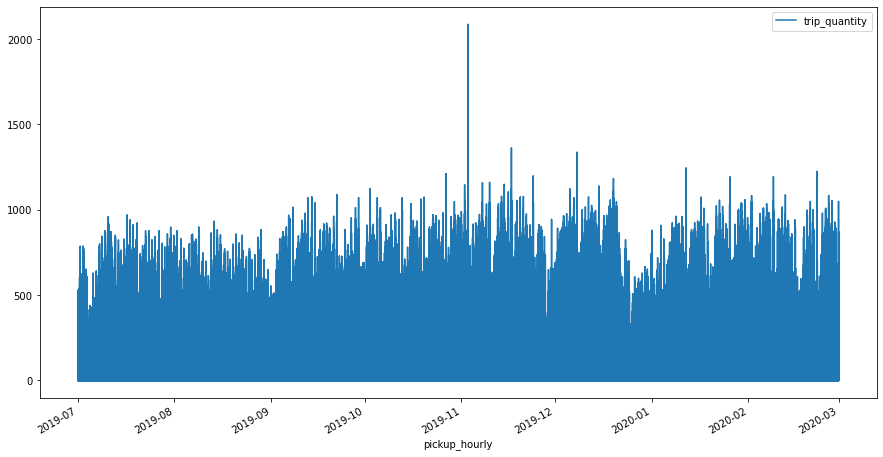

In [21]:
## PLOT OVERALL TIME SERIES - TO HELP INSPECT EXTREMES
df_raw.plot(x=timestamp, y=target_value, figsize=(15, 8))

In [22]:
# This is a very basic example of replacing extremes. In your implementation it should be done more carefully than this.

# Replace extreme value with treated median last n months values
months_to_use = 3

if (use_location):
    # with location_id 
    if (replace_extremes_with_mean & (templist < MAX_EXTREMES) & (templist > 0) ):

        df_clean = df_raw.copy()

        extremes = df_raw.loc[(df_raw[target_value]>=EXTREME_VALUE), :][[item_id, location_id if use_location else None, 'day_hour', timestamp]]

        for index, keys in extremes.iterrows():
            print (keys)

            # calculate median value from last n months before the extreme

            temp = df_raw.loc[((df_raw[item_id]==keys[item_id]) 
                               & (df_raw[location_id]==keys[location_id])
                               & (df_raw['day_hour']==keys['day_hour'])
                               & (df_raw[timestamp]<keys[timestamp])
                               & (df_raw[timestamp]>keys[timestamp] - relativedelta(months = months_to_use))), :] 

            # calculate median
            replace_extreme = temp[target_value].median() 
            print(replace_extreme)
            # visually check if replaced value looks like median target_value
            display(temp)

            # make the replacement
            df_clean.loc[((df_clean[item_id]==keys[item_id]) 
                               & (df_clean[location_id]==keys[location_id])
                               & (df_raw['day_hour']==keys['day_hour'])
                               & (df_clean[timestamp]==keys[timestamp])), target_value] = replace_extreme

            print(f"new value is {df_clean.loc[((df_clean[item_id]==keys[item_id]) & (df_clean[location_id]==keys[location_id]) & (df_clean[timestamp]==keys[timestamp])), target_value].max()}")

    else:
        print("No extreme values found or do not replace any extremes.")
        df_clean = df_raw.copy()     
else:
    # without location_id     
    if (replace_extremes_with_mean & (templist < MAX_EXTREMES) & (templist > 0) ):

        df_clean = df_raw.copy()

        extremes = df_raw.loc[(df_raw[target_value]>=EXTREME_VALUE), :][[item_id, 'day_hour', timestamp]]

        for index, keys in extremes.iterrows():
            print (keys)

            # calculate median value from last n months before the extreme

            temp = df_raw.loc[((df_raw[item_id]==keys[item_id]) 
                               & (df_raw['day_hour']==keys['day_hour'])
                               & (df_raw[timestamp]<keys[timestamp])
                               & (df_raw[timestamp]>keys[timestamp] - relativedelta(months = months_to_use))), :] 

            # calculate median
            replace_extreme = temp[target_value].median() 
            print(replace_extreme)
            # visually check if replaced value looks like median target_value
            display(temp)

            # make the replacement
            df_clean.loc[((df_clean[item_id]==keys[item_id]) 
                               & (df_raw['day_hour']==keys['day_hour'])
                               & (df_clean[timestamp]==keys[timestamp])), target_value] = replace_extreme

            print(f"new value is {df_clean.loc[((df_clean[item_id]==keys[item_id]) & (df_clean[timestamp]==keys[timestamp])), target_value].max()}")

    else:
        print("No extreme values found or do not replace any extremes.")
        df_clean = df_raw.copy()
    

No extreme values found or do not replace any extremes.


<AxesSubplot:xlabel='pickup_hourly'>

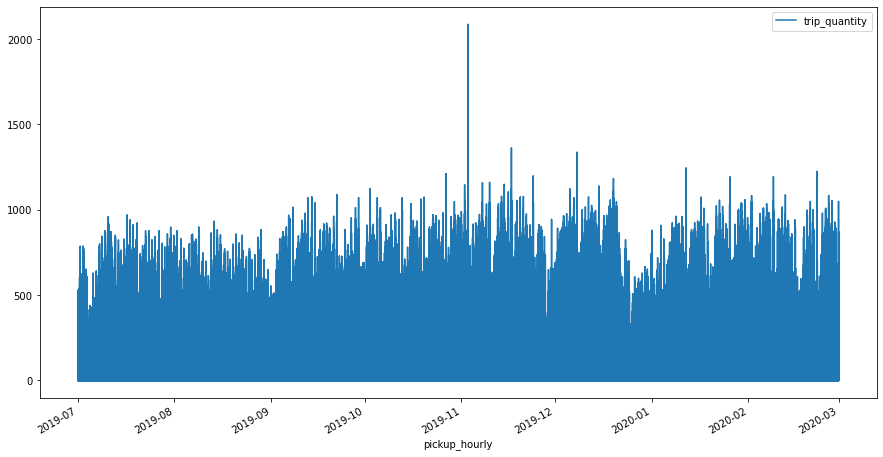

In [23]:
## PLOT THE CLEAN TIME SERIES - TO HELP INSPECT EXTREMES
df_clean.plot(x=timestamp, y=target_value, figsize=(15, 8))

In [24]:
# save some memory
del df_raw

In [25]:
# throws error if we lost some values
assert original_shape[0] == df_clean.shape[0]

## Step 8. Optional - Round negative targets up to 0 <a class="anchor" id="round_negatives"></a>

In [26]:
# Check negative values
print(df_clean.loc[(df_clean[target_value] <0), :].shape)
df_clean.loc[(df_clean[target_value] <0), :].sort_values([timestamp, item_id]).head()

(0, 9)


,pulocationid,pickup_hourly,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item


In [27]:
# CAREFUL!!  MAKE SURE ROUNDING NEGATIVES UP TO 0 MAKES SENSE FOR YOUR USE CASE

# If negative values found, round them up to 0
if df_clean.loc[(df_clean[target_value] <0), :].shape[0] > 0:

    # Check y-value before cleaning
    print(df_clean[target_value].describe())

    # default negative values in demand to 0
    print(f"{df_clean[target_value].lt(0).sum()} negative values will be rounded up to 0")
    print()
    ts_cols = [target_value]

    for c in ts_cols:
        df_clean.loc[(df_clean[c] < 0.0), c] = 0.0

    # Check y-value after cleaning
    print(df_clean[target_value].describe())
else:
    print("No negative values found.")

No negative values found.


## Step 9. Optional - Convert negative targets to nan <a class="anchor" id="negatives_to_nan"></a>

In [28]:
# # Check negative values
# print(df_clean.loc[(df_clean[target_value] <0), :].shape)
# df_clean.loc[(df_clean[target_value] <0), :].sort_values([timestamp, item_id]).head()

In [29]:
# # # CAREFUL!!  MAKE SURE CHANGING NEGATIVES TO NAN NEGATIVES MAKES SENSE FOR YOUR USE CASE

# # If negative values found, round them up to 0
# if df_clean.loc[(df_clean[target_value] <0), :].shape[0] > 0:

#     # Check y-value before cleaning
#     print(df_clean[target_value].describe())

#     # default negative values in demand to 0
#     print(f"{df_clean[target_value].lt(0).sum()} negative values will be rounded up to 0")
#     print()
#     ts_cols = [target_value]
    
#     print ()

#     for c in ts_cols:
#         df_clean.loc[(df_clean[c] < 0.0), c] = float('nan')
        
        

#     # Check y-value after cleaning
#     print(df_clean[target_value].describe())
# else:
#     print("No negative values found.")

In [30]:
# # throws error if we lost some values
# assert original_shape[0] == df_clean.shape[0]

## Step 10. Aggregate at your chosen frequency <a class="anchor" id="groupby_frequency"></a>

Below, we show an example of resampling at hourly frequency by forecast dimensions.  Modify the code to resample at other frequencies.

Decide which aggregation-level makes sense for your data, which is a balance between desired aggregation and what the data-collection frequency will support.

In [31]:
forecast_dims

['pickup_hourly', 'pulocationid']

In [32]:
## CHECK TO SEE IF YOUR TIMESERIES DIMENSIONS ARE CORRECT

# checking if there are multiple entries per item_id per timestamp per location
df_aux = df_clean.copy().set_index(forecast_dims)

duplicates = df_aux.pivot_table(index=forecast_dims, aggfunc='size')
duplicates = pd.DataFrame( duplicates, columns=["NumberPerTS"])

print (duplicates[duplicates["NumberPerTS"]>1].head())

Empty DataFrame
Columns: [NumberPerTS]
Index: []


In [33]:
# checking to see if your timeseries dimensions are correct
if duplicates[duplicates["NumberPerTS"]>1].shape[0] > 0:
    print("WARNING:  YOUR AGGREGATION ASSUMPTION THAT timestamp, item_id, location_id ARE UNIQUE IS NOT CORRECT.")
    print("Inspect df_aux where you see 'NumberPerTS' > 1")
else:
    print("Success!  timestamp, item_id, location_id is a unique grouping of your time series.")

Success!  timestamp, item_id, location_id is a unique grouping of your time series.


In case your assumed dimensions are not unique, code below is to explore adding a composite column.

In [34]:
####
# EDIT THIS FOR YOUR DATA
####

# #  inspect what is happening on these repeated items
# try:
#     df_aux.reset_index(inplace = True)
# except Exception as e:
#     print (e)

# test_aux = df_aux.loc[((df_aux[item_id]=='PRD-05685') & (df_aux[location_id]=='STCK-00605')
#                       & (df_aux[timestamp]=="2019-09-30 01:36:45")), :]
# test_aux.sort_values(by=[timestamp])

# # Possibly extra dimension Organization Name?

In [35]:
# # Since location is not unique, create new fake composite column
# df_clean['timeseries_key'] = df_clean[item_id] + '-'+ df_clean[location_id] \
#                                 + '-' + df_clean['Organization Name']
# df_clean.head(2)

In [36]:
# # If you changed dimensions, re-map expected column names
# item_id = "timeseries_key"
# use_location = False
# forecast_dims = [timestamp, item_id]
# print(f"forecast_dims = {forecast_dims}")
# dims_except_timestamp = [i for i in forecast_dims if i != timestamp]
# print(f"dims_except_timestamp = {dims_except_timestamp}")

In [37]:
# ## CHECK AGAIN TO SEE IF YOUR DATA AGGREGATION ASSUMPTION IS CORRECT

# # checking if there are multiple entries per item_id per timestamp per location
# df_aux = df_clean[forecast_dims + [target_value]].copy().set_index(forecast_dims)
# df_aux.drop_duplicates(inplace=True)

# duplicates = df_aux.pivot_table(index=forecast_dims, aggfunc='size')
# duplicates = pd.DataFrame( duplicates, columns=["NumberPerTS"])

# # checking to see if your data aggregation is correct
# if duplicates[duplicates["NumberPerTS"]>1].shape[0] > 0:
#     print (duplicates[duplicates["NumberPerTS"]>1].head())
#     print("WARNING:  YOUR AGGREGATION ASSUMPTION THAT timestamp, item_id, location_id ARE UNIQUE IS NOT CORRECT.")
#     print("Inspect df_aux where you see 'NumberPerTS' > 1")
# else:
#     print("Success!  timestamp, item_id, location_id is a unique grouping of your time series.")

In [38]:
print(f"forecast_dims = {forecast_dims}")
df_clean.head(1)

forecast_dims = ['pickup_hourly', 'pulocationid']


,pulocationid,pickup_hourly,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
0,1,2019-07-02 09:00:00,Tuesday,Tuesday_9,0,1.00000,40.68951565_-74.17678575,EWR,Cat_1


In [39]:
####
# EDIT THIS FOR YOUR DATA
####

# restrict columns if desired
# df_clean = df_clean[[timestamp, item_id, "Prod #", location_id, "Organization Name", target_value]].copy()
print(df_clean.shape)
df_clean.drop_duplicates(inplace=True)
print(df_clean.shape)

# Put all columns besides forecast_dims that you want to keep in a dictionary of aggregations (per
# pandas agg()):
agg_dict = {
    "pickup_day_of_week": "first",
    "day_hour": "first",
    "trip_quantity": "sum",
    "mean_item_loc_weekday": "mean",
    "pickup_geolocation": "first",
    "pickup_borough": "first",
    "binned_max_item": "last",
}

print("Validating agg_dict...")
for dim in forecast_dims:
    if dim in agg_dict:
        dim_agg = agg_dict[dim]
        if (type(dim_agg) == str) or not hasattr(dim_agg, "__iter__"):
            print(
                "Single aggregation on forecast dimension column not supported: Ignoring\n"
                f"({dim}: {dim_agg})"
            )
            del agg_dict[dim]

(1507488, 9)
(1507488, 9)
Validating agg_dict...


In [40]:
# # THIS CODE BLOCK IS AN EXAMPLE OF Weekly AGGREGATION
# g_week = local_util.dataprep.aggregate_time_series(
#     df_clean,
#     agg_freq="W",
#     timestamp_col=timestamp,
#     target_col=target_value,
#     dimension_cols=dims_except_timestamp,
#     agg_dict=agg_dict,
#     already_grouped=False,
#     analyze=True,
# )

# # add new time dimension since original timestamp is not weekly
# g_week['year_week'] = g_week[timestamp].dt.year.astype(str) + '_' \
#                         + g_week[timestamp].dt.isocalendar().week.astype(str)
# display(g_week.sample(5))

agg_freq='H'
already grouped: no-op
Analyzing timeseries length and sparsity
Data point count statistics:
count    260.00000
mean    5798.03077
std      449.40767
min      840.00000
25%     5856.00000
50%     5856.00000
75%     5856.00000
max     5856.00000
Name: trip_quantity, dtype: float64
Dense threshold 75.00% is at 5856.0 data points


,pulocationid,pickup_hourly,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
1090110,8,2019-07-26 15:00:00,Friday,Friday_15,0,1.08333,40.77860696_-73.92320241,Queens,Cat_1
642123,254,2020-02-10 03:00:00,Monday,Monday_3,0,1.08108,40.88322333_-73.85826965,Bronx,Cat_1
162639,193,2019-10-03 10:00:00,Thursday,Thursday_10,6,3.65320,40.76172443_-73.9402863,Queens,Cat_1
1336086,245,2019-07-17 00:00:00,Wednesday,Wednesday_0,0,1.00000,40.62847848_-74.10317061,Staten Island,Cat_1
946688,83,2020-01-29 12:00:00,Wednesday,Wednesday_12,0,1.41530,40.7401456_-73.88922183,Queens,Cat_1


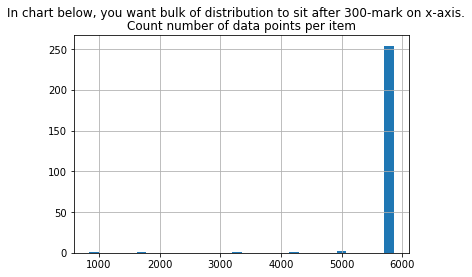

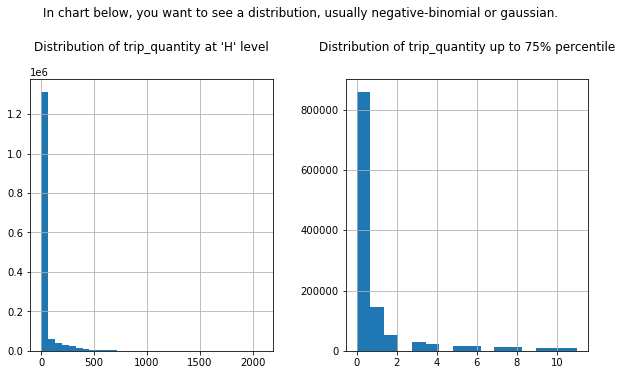

In [41]:
# THIS CODE BLOCK IS AN EXAMPLE OF Hourly AGGREGATION
# Note:  The sample data shipped with notebook is ideal - all time series have 5856 data points, 
# which is squarely in the Deep Learning desired data size.

g_hour = local_util.dataprep.aggregate_time_series(
    df_clean,
    agg_freq="H",
    timestamp_col=timestamp,
    target_col=target_value,
    dimension_cols=dims_except_timestamp,
    agg_dict=agg_dict,
    already_grouped=True,
    analyze=True,
)
display(g_hour.sample(5))

agg_freq='2H'
grouped shape = (268685, 9), original shape = (1507488, 9)


,pickup_hourly,pulocationid,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
119776,2019-09-08 04:00:00,45,Sunday,Sunday_5,12,15.27044,40.71305783_-73.99825262,Manhattan,Cat_1
146933,2019-10-03 18:00:00,142,Thursday,Thursday_19,1024,278.87024,40.77390599_-73.98135241,Manhattan,Cat_2
122497,2019-09-10 14:00:00,88,Tuesday,Tuesday_15,115,34.29197,40.7033938_-74.01130777,Manhattan,Cat_1
73139,2019-08-02 22:00:00,95,Friday,Friday_23,3,1.74364,40.72346527_-73.84821994,Queens,Cat_1
33623,2019-07-12 20:00:00,49,Friday,Friday_20,10,2.24470,40.68851588_-73.96493373,Brooklyn,Cat_1


Analyzing timeseries length and sparsity
Data point count statistics:
count    260.00000
mean    1033.40385
std      928.95345
min       25.00000
25%      342.75000
50%      497.50000
75%     1827.25000
max     2830.00000
Name: trip_quantity, dtype: float64
Dense threshold 75.00% is at 1827.25 data points


,pickup_hourly,pulocationid,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
130296,2019-09-17 16:00:00,181,Tuesday,Tuesday_16,5,5.87717,40.67201914_-73.9790449,Brooklyn,Cat_1
81366,2019-08-08 12:00:00,71,Thursday,Thursday_12,1,1.41667,40.64392852_-73.93773452,Brooklyn,Cat_1
88644,2019-08-13 18:00:00,262,Tuesday,Tuesday_18,205,116.91727,40.77653423_-73.94582982,Manhattan,Cat_1
173454,2019-11-01 02:00:00,116,Friday,Friday_2,12,10.50540,40.82753526_-73.94736754,Manhattan,Cat_1
209818,2019-12-13 16:00:00,246,Friday,Friday_16,440,150.52976,40.75243725_-74.00451257,Manhattan,Cat_2


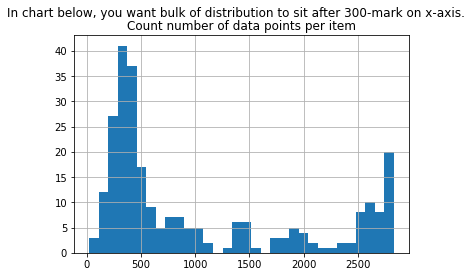

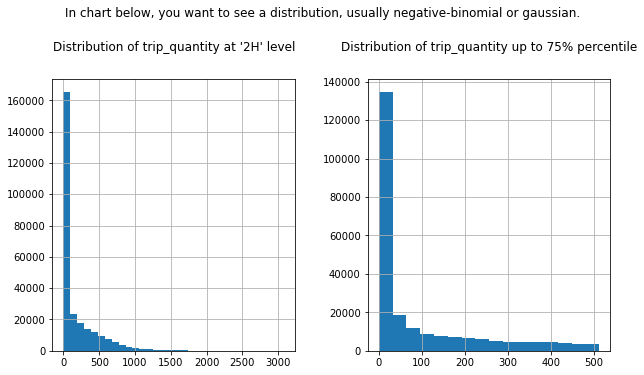

In [42]:
## TRY ANOTHER AGGREGATION LEVEL AND COMPARE TARGET_VALUE DISTRIBUTION SHAPES
agg_freq = "2H"

g_2hour = local_util.dataprep.aggregate_time_series(
    df_clean,
    "2H",
    timestamp_col=timestamp,
    target_col=target_value,
    dimension_cols=dims_except_timestamp,
    agg_dict=agg_dict,
)
display(g_2hour.sample(5))

agg_freq='4H'
grouped shape = (191908, 9), original shape = (1507488, 9)


,pickup_hourly,pulocationid,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
131387,2019-11-17 04:00:00,148,Sunday,Sunday_4,384,183.22917,40.71921167_-73.99071836,Manhattan,Cat_4
43919,2019-08-02 20:00:00,134,Friday,Friday_22,1,1.53061,40.70875018_-73.8299927,Queens,Cat_1
47656,2019-08-06 04:00:00,34,Tuesday,Tuesday_6,0,1.20213,40.70255904_-73.96769897,Brooklyn,Cat_1
27395,2019-07-20 00:00:00,257,Saturday,Saturday_2,0,1.17791,40.6536645_-73.97723931,Brooklyn,Cat_1
124421,2019-11-06 16:00:00,107,Wednesday,Wednesday_17,1008,202.28214,40.73734838_-73.98331035,Manhattan,Cat_2


Analyzing timeseries length and sparsity
Data point count statistics:
count    260.00000
mean     738.10769
std      455.66935
min       25.00000
25%      364.00000
50%      544.00000
75%     1241.75000
max     1452.00000
Name: trip_quantity, dtype: float64
Dense threshold 75.00% is at 1241.75 data points


,pickup_hourly,pulocationid,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
82511,2019-09-11 20:00:00,161,Wednesday,Wednesday_20,3061,430.59643,40.75822648_-73.97743184,Manhattan,Cat_3
84029,2019-09-13 16:00:00,136,Friday,Friday_17,4,1.13873,40.86480273_-73.90571997,Bronx,Cat_1
153633,2019-12-22 16:00:00,190,Sunday,Sunday_17,2,1.39500,40.66060757_-73.97095007,Brooklyn,Cat_1
83643,2019-09-13 04:00:00,237,Friday,Friday_7,748,405.52262,40.76854188_-73.96569149,Manhattan,Cat_3
124250,2019-11-06 08:00:00,32,Wednesday,Wednesday_9,1,1.14118,40.86445171_-73.86462414,Bronx,Cat_1


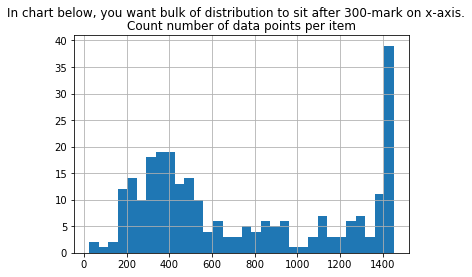

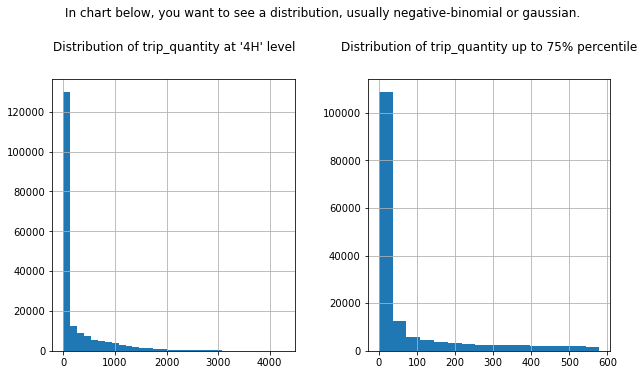

In [43]:
## TRY ANOTHER AGGREGATION LEVEL AND COMPARE TARGET_VALUE DISTRIBUTION SHAPES
agg_freq = "4H"

g_4hour = local_util.dataprep.aggregate_time_series(
    df_clean,
    "4H",
    timestamp_col=timestamp,
    target_col=target_value,
    dimension_cols=dims_except_timestamp,
    agg_dict=agg_dict,
)
display(g_4hour.sample(5))

<br>

<b> Select the aggregation-level to keep, based on results above.</b>

In [44]:
## USE THE GROUPING YOU SELECTED ABOVE
df = g_hour.copy()

# Delete no-longer-needed aggregations to save memory:
del df_aux
del g_hour
del g_2hour
del g_4hour

print(df.shape, df_clean.shape)
df.sample(5)

(1507488, 9) (1507488, 9)


,pulocationid,pickup_hourly,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
173462,89,2020-01-20 10:00:00,Monday,Monday_10,1,1.38827,40.64098273_-73.96269373,Brooklyn,Cat_1
595126,31,2019-11-15 21:00:00,Friday,Friday_21,1,1.00000,40.85992052_-73.87572205,Bronx,Cat_1
207316,175,2020-02-18 14:00:00,Tuesday,Tuesday_14,0,1.03030,40.74327385_-73.75735677,Queens,Cat_1
1102924,187,2019-08-27 22:00:00,Tuesday,Tuesday_22,0,1.00000,40.62545372_-74.14115248,Staten Island,Cat_1
371442,194,2019-12-05 14:00:00,Thursday,Thursday_14,0,1.33224,40.79143296_-73.92102903,Manhattan,Cat_1


## Step 11. Typical retail scenarios: Find top-moving items <a class="anchor" id="top_moving_items"></a>

Next, we want to drill down and visualize some individual item time series.  Typically customers have "catalog-type" data, where only the top 20% of their items are top-movers; the rest of the 80% of items are not top-movers.  For visualization, we want to select automatically some of the top-moving items.

In [45]:
use_location

False

In [46]:
%%time
print(f"Calculating per item{'+location' if use_location else ''} velocities")
top_movers, slow_movers = local_util.analysis.get_top_moving_items(
    df,
    timestamp,
    target_value,
    item_id,
    location_id if use_location else None,
)

Calculating per item velocities
average velocity of all items: 8011.673397435901
Found 47 top-moving time series (18.08% of total)
Found 213 slow-moving time series (81.92% of total)

Top moving:


,pulocationid,time_span,trip_quantity,velocity,top_moving
150,237,24.00000,2234548,93106.16667,True
66,161,24.00000,2121595,88399.79167,True
149,236,24.00000,2005360,83556.66667,True



Slowest moving:


,pulocationid,time_span,trip_quantity,velocity,top_moving
107,199,24.00000,8,0.33333,False
82,176,24.00000,7,0.29167,False
114,204,24.00000,1,0.04167,False


CPU times: user 18.4 s, sys: 678 ms, total: 19 s
Wall time: 19.1 s


In [47]:
n_random = 5
print(f"Selecting {n_random} random top-moving series for plotting:")
random_series = top_movers.sample(
    n_random,
    random_state=42,
).index.to_frame().reset_index(drop=True)
random_series

Selecting 5 random top-moving series for plotting:


,pulocationid
0,231
1,13
2,90
3,87
4,140


In [48]:
# Alternatively, you could explicitly specify some dimension combinations you'd like to explore:

# random_series = pd.DataFrame({
#     item_id: ["79", "135"],
#     location_id: ["here", "there"],
# })
# random_series

## Step12. Visualize time series <a class="anchor" id="visualize"></a>

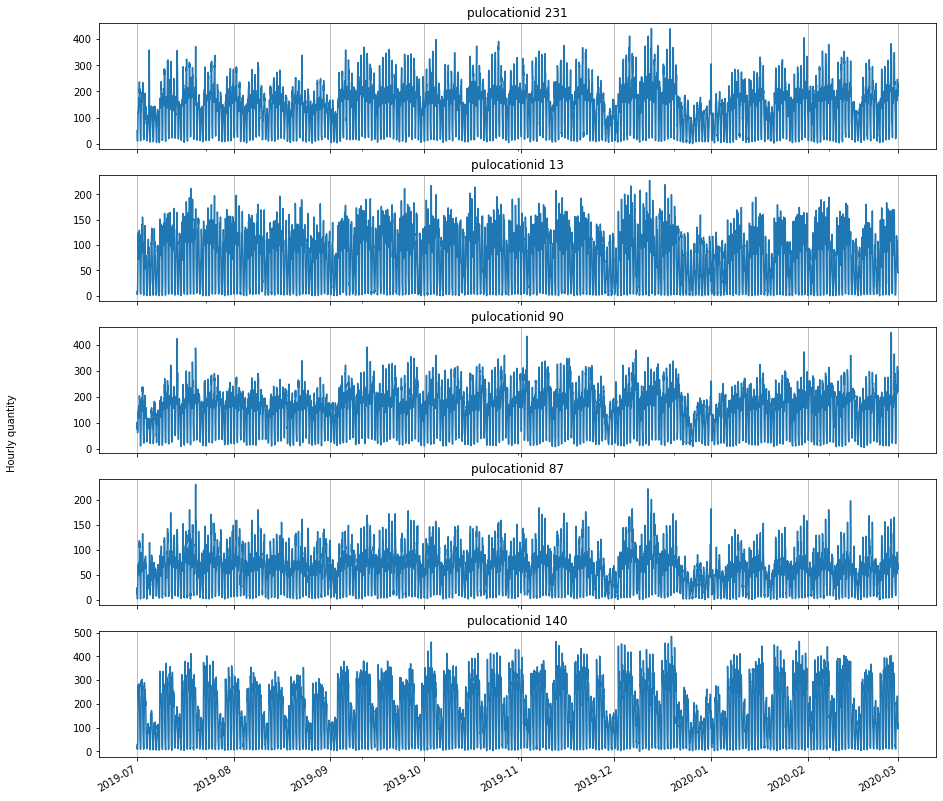

In [49]:
df_plot = local_util.dataprep.select_by_df(df, random_series)

df_plot.set_index(timestamp, inplace=True)
df_plot.head(2)

local_util.plotting.make_plots(
    df_plot,
    random_series,
    target_value,
    "Hourly quantity",
)

## Step 13. Split train/test data  <a class="anchor" id="split_train_test"></a> 

In forecasting, "train" data is until a last-train date, sometimes called the forecast snapshot date.  
<ul>
    <li>Train data includes all data up to your last-train date. </li>
    <li>Test data includes dates after your last-train date through end of desired forecast horizon.</li>
    <li>Validation data might exist for part or maybe all of the desired forecast horizon. </li>
    <li>TTS timestamps should start and end with Train data. </li>
    <li>RTS timestamps should start with Train data and extend out past end of TTS to end of the desired forecast horizon.</li>
    </ul>
    
For model generalization, all processing from here on out will only be done on train data.

In [50]:
# Forecast Horizon is number of time steps out in the future you want to predict
# Time steps are defined in the time frequency you specified in Step 5 Aggregate

# Example if aggregation was hourly, then forecast length=168 means forecast horizon of 7 days or 7*24=168 hours
print(f"Forecast horizon = {FORECAST_LENGTH}") # = 12
print(f"Forecast unit of frequency = {AF_freq_to_dateutil_freq[FORECAST_FREQ]}") # = 30
print(f"Forecast start date = {SNAPSHOT_DATE}")

Forecast horizon = 168
Forecast unit of frequency = hours
Forecast start date = 2020-02-23 00:00:00


In [51]:
# Create train data as all except last FORECAST_HORIZON length
start_time = df[timestamp].min()
end_time = snapshot_end
start_time_test = SNAPSHOT_DATE

print(f"start_time = {start_time}")
print(f"end_time_train = {end_time_train}")
print(f"start_time_test = {start_time_test}")
print(f"end_time = {snapshot_end}")

start_time = 2019-07-01 00:00:00
end_time_train = 2020-02-22 23:00:00
start_time_test = 2020-02-23 00:00:00
end_time = 2020-02-29 23:00:00


In [52]:
create_future_RTS_with_unknown_data

False

In [53]:
if create_future_RTS_with_unknown_data:
    # Create train data as all data => this means RTS will extend into unknown future
    print("using all known data for training")
    train_df = df.copy()
else:
    # Create train subset with hold-out of length FORECAST_LENGTH
    print("using hold-out with train data")
    train_df = df.copy()
    train_df = train_df.loc[(train_df[timestamp] <= end_time_train), :]

# check you did the right thing
print(f"start_time = {start_time}")
print(f"end_time: {end_time}")
print()
print(f"start_time_train = {train_df[timestamp].min()}")
print(f"end_time_train = {train_df[timestamp].max()}")
train_df.head()

using hold-out with train data
start_time = 2019-07-01 00:00:00
end_time: 2020-02-29 23:00:00

start_time_train = 2019-07-01 00:00:00
end_time_train = 2020-02-22 23:00:00


,pulocationid,pickup_hourly,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
0,1,2019-07-02 09:00:00,Tuesday,Tuesday_9,0,1.00000,40.68951565_-74.17678575,EWR,Cat_1
1,1,2019-07-03 01:00:00,Wednesday,Wednesday_1,0,1.05769,40.68951565_-74.17678575,EWR,Cat_1
2,1,2019-07-05 06:00:00,Friday,Friday_6,0,1.13208,40.68951565_-74.17678575,EWR,Cat_1
3,1,2019-07-06 08:00:00,Saturday,Saturday_8,0,1.08333,40.68951565_-74.17678575,EWR,Cat_1
4,1,2019-07-26 17:00:00,Friday,Friday_17,0,1.13208,40.68951565_-74.17678575,EWR,Cat_1


In [54]:
# ERROR CHECK: DO YOU HAVE ENOUGH HISTORICAL DATA POINTS TO SUPPORT DESIRED FORECAST HORIZON?

# calculate number data points in train data
num_data_points = train_df.groupby(dims_except_timestamp).nunique()[timestamp].mean()
print(f"1/3 training data points: {np.round(num_data_points/3,0)}")

# Amazon Forecast length of forecasts can be 500 data points and 1/3 target time series dataset len
if ((FORECAST_LENGTH < 500) & (FORECAST_LENGTH <= np.round(num_data_points/3,0))):
    print("".join((
        f"Success, forecast horizon {FORECAST_LENGTH} is shorter than 500 data points and less ",
        "than 1/3 of the historical training data length.",
    )))
else:
    raise ValueError("".join((
        f"Error, forecast horizon {FORECAST_LENGTH} is too long. Must be fewer than 500 data ",
        "points and less than 1/3 of the historical training data length.",
    )))
    
# If you have too few data points, return to step above and choose smaller time granularity

1/3 training data points: 1877.0
Success, forecast horizon 168 is shorter than 500 data points and less than 1/3 of the historical training data length.


## Step 14. Prepare and Save Target Time Series (TTS) <a class="anchor" id="TTS"></a>

In [55]:
print(create_future_RTS_with_unknown_data)
print(f"forecast_dims: {forecast_dims}")
print(f"geolocation: {geolocation}")
train_df.head(1)

False
forecast_dims: ['pickup_hourly', 'pulocationid']
geolocation: pickup_geolocation


,pulocationid,pickup_hourly,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
0,1,2019-07-02 09:00:00,Tuesday,Tuesday_9,0,1.00000,40.68951565_-74.17678575,EWR,Cat_1


In [56]:
## Assemble TTS required columns

####
# EDIT THIS FOR YOUR DATA
####
if geolocation is not None:
    print("Preparing TTS with geolocation data")
    # restrict train data to just tts columns
    tts = train_df[forecast_dims + [geolocation, target_value]].copy()
    tts = tts.groupby(forecast_dims+[geolocation])[[target_value]].sum()
else:
    print("Running without geolocation data")
    # restrict train data to just tts columns
    tts = train_df[forecast_dims + [target_value]].copy()
    tts = train_df[[timestamp, item_id, target_value]].copy()
    tts = tts.groupby(forecast_dims)[[target_value]].sum()
    
tts.reset_index(inplace=True)
print(f"start date = {tts[timestamp].min()}")
print(f"end date = {tts[timestamp].max()}")

# check it
print(tts.shape)
print(tts.dtypes)
tts.head(5)

Preparing TTS with geolocation data
start date = 2019-07-01 00:00:00
end date = 2020-02-22 23:00:00
(1464240, 4)
pickup_hourly         datetime64[ns]
pulocationid                  object
pickup_geolocation            object
trip_quantity                  int32
dtype: object


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
0,2019-07-01,1,40.68951565_-74.17678575,0
1,2019-07-01,10,40.6781247_-73.79166546,1
2,2019-07-01,100,40.75351409_-73.98878589,104
3,2019-07-01,101,40.74372178_-73.70907059,0
4,2019-07-01,102,40.70267936_-73.88199873,0


In [57]:
# check format of geolocation column
# tts[geolocation].value_counts(normalize=True, dropna=False)

<b>Optional - convert target_value to integer if this is the last step for TTS. </b>

Note: Currently in Amazon Forecast, if you declare target_value is integer in the schema, but you have any decimals in your numbers, you will get an error.

Make sure you really see integers in the code below, if you want integers!

In [58]:
target_to_integer

False

In [59]:
# Use the new pandas Integer type
# https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html
# TODO: turn this into a function

if target_to_integer:
    try:
        tts[target_value] = tts[target_value].astype(int)
        print("Success! Converted to numpy integer")
    except Exception as e:
        print (e)
        print("Trying pandas nullable Integer type instead of numpy integer type...")
        try:
            tts[target_value] = tts[target_value].astype('Int64', errors='ignore')
            print("Success! converted to pandas integer")
        except Exception as e:
            print (e)
elif tts[target_value].dtype == 'object':
    # convert to float
    tts[target_value] = tts[target_value].astype(np.float32)
elif tts[target_value].dtype != 'object':
    # do nothing
    print("target_value is already a float")
    
print(tts.dtypes)
tts.sample(5)

target_value is already a float
pickup_hourly         datetime64[ns]
pulocationid                  object
pickup_geolocation            object
trip_quantity                  int32
dtype: object


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
660691,2019-10-15 22:00:00,237,40.76854188_-73.96569149,420
614488,2019-10-08 11:00:00,120,40.84600407_-73.93080685,0
447084,2019-09-11 08:00:00,50,40.76669237_-73.9938994,125
1288130,2020-01-25 11:00:00,8,40.77860696_-73.92320241,0
382631,2019-08-31 22:00:00,2,40.62572424_-73.82612577,0


## Step 15. Remove time series with no target values at all<a class="anchor" id="TTS_remove_all0"></a>
In case there are time series which are only 0's, may as well remove them, since their forecast should be all 0's too.  Another reason to remove these time series is they could bias the overall forecast toward 0, when that's not what you want.

In [60]:
print(tts.shape)
tts.dtypes

(1464240, 4)


pickup_hourly         datetime64[ns]
pulocationid                  object
pickup_geolocation            object
trip_quantity                  int32
dtype: object

In [61]:
# check if sum of all sales is 0
g = tts.groupby(dims_except_timestamp).sum()
g.fillna(0, inplace=True)
skus_with_no_sales_in_warehouse = g[g[target_value] == 0].copy()

# drop extra columns for cleaner merge
skus_with_no_sales_in_warehouse.reset_index(inplace=True)
skus_with_no_sales_in_warehouse = skus_with_no_sales_in_warehouse.iloc[:, 0:1]
skus_with_no_sales_in_warehouse.drop_duplicates(inplace=True)
display (skus_with_no_sales_in_warehouse.head(2))

if skus_with_no_sales_in_warehouse.shape[0] > 0:
        
    # https://stackoverflow.com/questions/32676027/how-to-do-df1-not-df2-dataframe-merge-in-pandas
    tts_copy = tts.merge(skus_with_no_sales_in_warehouse, how='left', on=dims_except_timestamp, indicator=True) \
               .query("_merge=='left_only'") \
               .drop('_merge',1)

    print(tts.shape, tts_copy.shape)
    display(tts_copy.sample(5))

else:
    print("No time series found with only 0's.")

,pulocationid


No time series found with only 0's.


In [62]:
# really drop skus with only 0's

if skus_with_no_sales_in_warehouse.shape[0] > 0:
    print(tts.shape, tts_copy.shape)
    tts = tts_copy.copy()
    del (tts_copy)
    
    # keep track of dropped dimensions and reason why dropped
    skus_with_no_sales_in_warehouse = skus_with_no_sales_in_warehouse[dims_except_timestamp].copy()
    
    # save the reason
    skus_with_no_sales_in_warehouse['reason'] = "All 0's"
    display(skus_with_no_sales_in_warehouse.head(2))
    
    print(tts.shape)
    display(tts.sample(5))

else:
    print("Didn't drop anything")

Didn't drop anything


## Step 16. Remove time series with end of life<a class="anchor" id="TTS_remove_end_of_life"></a>

Check if time series have any data in last 6 months and more than 5 data points, since 5 data points is minimum for Amazon Forecast to generate forecasts.

In [63]:
print(tts.shape)
tts.dtypes

(1464240, 4)


pickup_hourly         datetime64[ns]
pulocationid                  object
pickup_geolocation            object
trip_quantity                  int32
dtype: object

In [64]:
# Define end of life = No sales in the last 6 months

# first get df of only last 6 months
time_threshold = end_time - datetime.timedelta(6*30) 

# check if sum of sales last 6 months is 0
tts_aux = tts[tts[timestamp] >= time_threshold].copy()
g = tts_aux.groupby(dims_except_timestamp).sum()
g.fillna(0, inplace=True)
skus_with_end_of_life = g[g[target_value] == 0].copy()

# drop extra columns for cleaner merge
skus_with_end_of_life.reset_index(inplace=True)
skus_with_end_of_life = skus_with_end_of_life.iloc[:, 0:1]
skus_with_end_of_life.drop_duplicates(inplace=True)
display (skus_with_end_of_life.head(2))

if skus_with_end_of_life.shape[0] > 0:

    # https://stackoverflow.com/questions/32676027/how-to-do-df1-not-df2-dataframe-merge-in-pandas
    tts_copy = tts.merge(skus_with_end_of_life, how='left', on=dims_except_timestamp, indicator=True) \
               .query("_merge=='left_only'") \
               .drop('_merge',1)

    print(tts.shape, tts_copy.shape)
    display(tts_copy.sample(5))

else:
    print("No time series found with end of life.")

,pulocationid


No time series found with end of life.


In [65]:
# really drop the skus with end of life

if skus_with_end_of_life.shape[0] > 0:
    print(tts.shape, tts_copy.shape)
    tts = tts_copy.copy()
    del (tts_copy)
    display(tts.dtypes)
    
    # keep track of dropped dimensions and reason
    skus_with_end_of_life = skus_with_end_of_life[dims_except_timestamp].copy()
    skus_with_end_of_life['reason'] = "end of life"
    display(skus_with_end_of_life.head(2))
    
    print(tts.shape)
    display(tts.sample(5))
    
else:
    print("Didn't drop anything")

Didn't drop anything


## Step 17. Remove time series with fewer than 5 data points<a class="anchor" id="TTS_remove_too_few_data_points"></a>

Minimum number of data points is 5 data points to make a forecast.  <br>

**Note: special consideration for cold-start or new product introductions**.  For best results, do not include new items in your training data.  However, do include new items in your inference data.  Notice that there is a system constraint such that at least 5 data points need to exist for each time series. Therefore, for the item that has less than 5 observations, be sure that item's target_value is encoded as float and fill explicitly with "NaN".  Also note: Cold-start forecasting only works if new items are tied to items with longer histories through Item Metadata. 

Run this to remove rows with <5 values (not explicitly "NaN") manually and save the list of time series with too few data points for your own reference.  Otherwise if you skip this section, Forecast will automatically drop (silently) all time series with fewer than 5 data points, since that is too few to make a good forecast. 

In [66]:
print(tts.shape)
tts.sample(5)

(1464240, 4)


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
341532,2019-08-25 06:00:00,4,40.72415214_-73.97702292,7
810356,2019-11-09 03:00:00,96,40.69576099_-73.87601222,0
541924,2019-09-26 17:00:00,18,40.86876288_-73.88692199,0
137648,2019-07-23 06:00:00,41,40.80420483_-73.95206533,27
1184816,2020-01-08 18:00:00,23,40.60750422_-74.15944329,0


<b>Replacing '0's with null</b>

In [67]:
replace_all_zeroes_with_null

False

In [68]:
# # Null-value filling, if any

# special case:  replace 0s with nulls
if (replace_all_zeroes_with_null):
    print(tts.shape)
    print(tts[target_value].describe())
    if target_to_integer:
        tts.loc[(tts[target_value]==0), target_value] = pd.NA
    else:
        tts.loc[(tts[target_value]==0), target_value] = np.nan
    print ()
    print(tts.shape)
    print(tts[target_value].describe())
else:
    tts.loc[:, target_value].fillna(0, inplace=True)
    print("No null-filling required.")

No null-filling required.


In [69]:
# check per time series if count of data points is at least 5
g = tts.groupby(dims_except_timestamp).count()
skus_with_too_few_sales = g[g[target_value] < 5].copy()

# drop extra columns for cleaner merge
skus_with_too_few_sales.reset_index(inplace=True)
skus_with_too_few_sales = skus_with_too_few_sales.iloc[:, 0:1]
skus_with_too_few_sales.drop_duplicates(inplace=True)
display (skus_with_too_few_sales.head(2))

if skus_with_too_few_sales.shape[0] > 0:

    # https://stackoverflow.com/questions/32676027/how-to-do-df1-not-df2-dataframe-merge-in-pandas
    tts_copy = tts.merge(skus_with_too_few_sales, how='left', on=dims_except_timestamp, indicator=True) \
               .query("_merge=='left_only'") \
               .drop('_merge',1)

    print("TTS if you dropped items with too few data points")
    print(tts.shape, tts_copy.shape)
    display(tts_copy.sample(5))

else:
    print("No time series found with fewer than 5 datapoints.")

,pulocationid


No time series found with fewer than 5 datapoints.


In [70]:
# really drop skus with too few data points, only if more than a handful found

if skus_with_too_few_sales.shape[0] > 0:
    print(tts.shape, tts_copy.shape)
    tts = tts_copy.copy()
    del (tts_copy)
    
    # keep track of dropped dimensions and reason why dropped
    skus_with_too_few_sales = skus_with_too_few_sales[dims_except_timestamp].copy()
    skus_with_too_few_sales['reason'] = "Fewer than 5 datapoints"
    display(skus_with_too_few_sales.head(2))
    
    print(tts.shape)
    display(tts.sample(5))
    
else:
    print("Didn't drop anything")

Didn't drop anything


<b> Keep track of dropped time series and reason why they were dropped. </b>

In [71]:
if skus_with_too_few_sales.shape[0] > 0:
    dropped_dims = skus_with_too_few_sales.append([skus_with_no_sales_in_warehouse
                                                       , skus_with_end_of_life])
    print(f"unique ts dropped = {dropped_dims.shape[0]}")
    print(f"unique ts fewer than 5 data points = {skus_with_too_few_sales.shape[0]}")
    print(f"unique ts with all 0s = {skus_with_no_sales_in_warehouse.shape[0]}")
    print(f"unique ts with end of life = {skus_with_end_of_life.shape[0]}")
    display(dropped_dims.reason.value_counts(dropna=False, normalize=True))
    display(dropped_dims.sample(1))
else:
    print("Didn't drop anything")

Didn't drop anything


In [72]:
# save list of dropped skus and reasons for reference and to check if data can be fixed

if skus_with_too_few_sales.shape[0] > 2:
    # save all the dropped dimensions fields
    local_file = "data/dropped_fields.csv"
    # Save merged file locally
    dropped_dims.to_csv(local_file, header=True, index=False)

    key = f"{prefix}/v{DATA_VERSION}/dropped_{EXPERIMENT_NAME}.csv"
    boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

<b>Optional - convert target_value to integer if this is last step for TTS. </b>

In [73]:
print(tts.shape)
display(tts.dtypes)
tts.head(5)

(1464240, 4)


pickup_hourly         datetime64[ns]
pulocationid                  object
pickup_geolocation            object
trip_quantity                  int32
dtype: object

,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
0,2019-07-01,1,40.68951565_-74.17678575,0
1,2019-07-01,10,40.6781247_-73.79166546,1
2,2019-07-01,100,40.75351409_-73.98878589,104
3,2019-07-01,101,40.74372178_-73.70907059,0
4,2019-07-01,102,40.70267936_-73.88199873,0


In [74]:
target_to_integer

False

In [75]:
# Use the new pandas Integer type
# https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html

if target_to_integer:
    try:
        tts[target_value] = tts[target_value].fillna(0).astype(int)
        print("Success! Converted to np.integer type")
    except Exception as e:
        print (e)
        print("Trying pandas nullable Integer type instead of numpy integer type...")
        try:
            tts[target_value] = tts[target_value].astype('Int64', errors='ignore')
            print("Success! Converted to nullable pd.integer type")
        except Exception as e:
            print (e)
elif tts[target_value].dtype == 'object':
    # convert to float
    tts[target_value] = tts[target_value].astype(np.float32)
elif tts[target_value].dtype != 'object':
    # do nothing
    print("target_value is already a float")
    
print(tts.dtypes)
tts.sample(5)

target_value is already a float
pickup_hourly         datetime64[ns]
pulocationid                  object
pickup_geolocation            object
trip_quantity                  int32
dtype: object


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
190201,2019-07-31 18:00:00,73,40.75369749_-73.80658433,0
392315,2019-09-02 11:00:00,99,40.57961795_-74.18770274,0
936196,2019-11-29 12:00:00,75,40.79065016_-73.94495667,64
67585,2019-07-11 22:00:00,49,40.68851588_-73.96493373,2
1043993,2019-12-16 23:00:00,221,40.62022398_-74.08133476,0


<b> Optional - replace 0's with nulls </b>

In [76]:
replace_all_zeroes_with_null

False

In [77]:
if replace_all_zeroes_with_null:
    tts.loc[(tts[target_value]==0), target_value] = pd.NA
    
print(tts[target_value].describe())
print(tts.dtypes)
tts.sample(5)

count   1464240.00000
mean         33.12328
std          94.41916
min           0.00000
25%           0.00000
50%           0.00000
75%           6.00000
max        2085.00000
Name: trip_quantity, dtype: float64
pickup_hourly         datetime64[ns]
pulocationid                  object
pickup_geolocation            object
trip_quantity                  int32
dtype: object


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
140490,2019-07-23 17:00:00,55,40.57689962_-73.99047414,0
172272,2019-07-28 21:00:00,150,40.58026232_-73.94288426,0
97695,2019-07-16 19:00:00,236,40.78049148_-73.95697239,445
944262,2019-11-30 20:00:00,129,40.75905747_-73.88740638,0
711441,2019-10-24 03:00:00,31,40.85992052_-73.87572205,0


In [78]:
# one last check...
print(tts.shape)
tts.drop_duplicates(inplace=True)
print(tts.shape)
print(tts[timestamp].min())
print(tts[timestamp].max())
# check for nulls
print(tts.isnull().sum())
print(tts.dtypes)
tts.sample(5)

(1464240, 4)
(1464240, 4)
2019-07-01 00:00:00
2020-02-22 23:00:00
pickup_hourly         0
pulocationid          0
pickup_geolocation    0
trip_quantity         0
dtype: int64
pickup_hourly         datetime64[ns]
pulocationid                  object
pickup_geolocation            object
trip_quantity                  int32
dtype: object


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
849339,2019-11-15 11:00:00,22,40.60962734_-73.99429702,0
133432,2019-07-22 14:00:00,184,40.86478542_-73.80461084,0
447589,2019-09-11 10:00:00,40,40.67850422_-73.99581808,3
1344143,2020-02-03 13:00:00,207,40.76351135_-73.89932502,0
53630,2019-07-09 16:00:00,194,40.79143296_-73.92102903,1


In [79]:
# Check input numbers of time series
if skus_with_too_few_sales.shape[0] > 0:
    dropped = dropped_dims.groupby(dims_except_timestamp).first().shape[0]
    display(dropped)
    # check
    assert (train_df.groupby(dims_except_timestamp).first().shape[0] \
            == (tts.groupby(dims_except_timestamp).first().shape[0] + dropped))

In [80]:
# Save tts to S3
local_file = "data/tts.csv"
# Save merged file locally
tts.to_csv(local_file, header=False, index=False)
print(f"Saved TTS locally to {local_file}")

key = f"{prefix}/v{DATA_VERSION}/{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)
print(f"Uploaded TTS to s3://{bucket_name}/{key}")

Saved TTS locally to data/tts.csv
Uploaded TTS to s3://674465894274-forecast-demo-taxi/nyc-taxi-trips/v1/nyctaxi_snap02232020_168H.csv


## Step 18. Optional - Assemble and save TTS_sparse, TTS_dense <a class="anchor" id="TTS-dense_sparse"></a>

In [81]:
dims_except_timestamp

['pulocationid']

Analyzing timeseries length and sparsity
Data point count statistics:
count    260.00000
mean    5631.69231
std      436.51399
min      816.00000
25%     5688.00000
50%     5688.00000
75%     5688.00000
max     5688.00000
Name: trip_quantity, dtype: float64
Dense threshold 75.00% is at 5688.0 data points


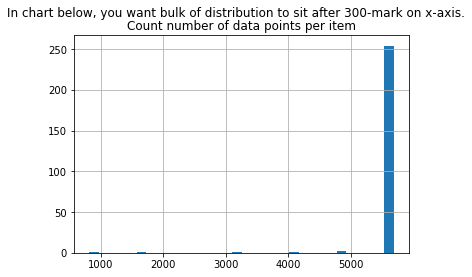

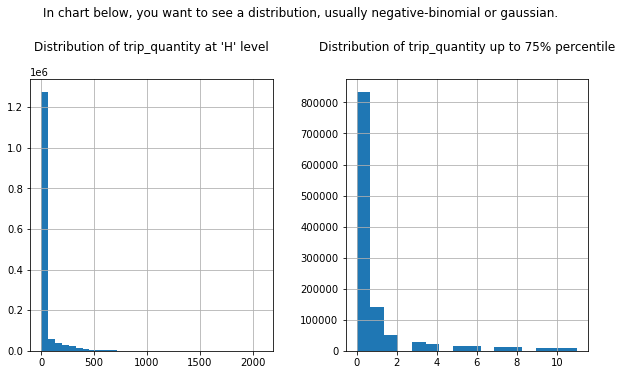

In [82]:
dense, sparse = local_util.analysis.analyze_lengths_and_sparsity(
    tts,
    agg_freq="H",
    target_col=target_value,
    forecast_dims=dims_except_timestamp,
    dense_threshold_quantile=0.75,
)

In [83]:
print(f"Found {len(dense)} dense timeseries")
print("Datapoint count of densest items/timeseries:")
display(dense.head())
print(f"\nFound {len(sparse)} sparse timeseries")
print("Datapoint count of sparsest items/timeseries:")
display(sparse.tail())

Found 254 dense timeseries
Datapoint count of densest items/timeseries:


pulocationid
1      5688
40     5688
25     5688
250    5688
251    5688
Name: trip_quantity, dtype: int64


Found 6 sparse timeseries
Datapoint count of sparsest items/timeseries:


pulocationid
187    4872
30     4056
176    3240
199    1632
204     816
Name: trip_quantity, dtype: int64

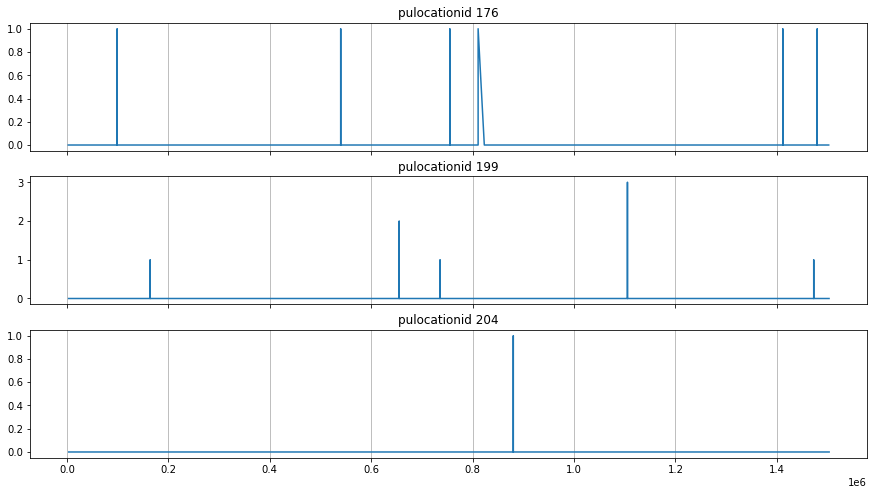

In [84]:
# Spot check some sparse time-series:
local_util.plotting.make_plots(
    df,
    sparse.tail(3).index.to_frame(),
    target_value,
)

In [85]:
# save sparse dimensions
local_file = "data/sparse_fields.csv"
# Save merged file locally
sparse.reset_index().to_csv(local_file, header=False, index=False)
print(f"Saved sparse dimensions locally to {local_file}")

key = f"{prefix}/v{DATA_VERSION}/sparse_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)
print(f"Uploaded to s3://{bucket_name}/{key}")

Saved sparse dimensions locally to data/sparse_fields.csv
Uploaded to s3://674465894274-forecast-demo-taxi/nyc-taxi-trips/v1/sparse_nyctaxi_snap02232020_168H.csv


In [86]:
# save dense dimensions
local_file = "data/dense_fields.csv"
# Save merged file locally
dense.reset_index().to_csv(local_file, header=False, index=False)
print(f"Saved dense dimensions locally to {local_file}")

key = f"{prefix}/v{DATA_VERSION}/dense_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)
print(f"Uploaded to s3://{bucket_name}/{key}")

Saved dense dimensions locally to data/dense_fields.csv
Uploaded to s3://674465894274-forecast-demo-taxi/nyc-taxi-trips/v1/dense_nyctaxi_snap02232020_168H.csv


In [87]:
tts_dense = local_util.dataprep.select_by_df(tts, dense.index.to_frame()).copy()
print(tts_dense.shape, tts.shape)
tts_dense.sample(5)

(1444752, 4) (1464240, 4)


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
835836,2019-11-13 06:00:00,83,40.7401456_-73.88922183,3
173678,2019-07-29 02:00:00,26,40.62861224_-73.98956041,0
712004,2019-10-24 05:00:00,8,40.77860696_-73.92320241,0
553352,2019-09-28 13:00:00,246,40.75243725_-74.00451257,251
1353880,2020-02-05 03:00:00,177,40.67709861_-73.91110579,0


In [88]:
# Save tts_dense to S3
local_file = "data/tts_dense.csv"
# Save merged file locally
tts_dense.to_csv(local_file, header=False, index=False)
print(f"Saved dense-only TTS locally to {local_file}")

key = f"{prefix}/v{DATA_VERSION}/tts_dense_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)
print(f"Uploaded to s3://{bucket_name}/{key}")

Saved dense-only TTS locally to data/tts_dense.csv
Uploaded to s3://674465894274-forecast-demo-taxi/nyc-taxi-trips/v1/tts_dense_nyctaxi_snap02232020_168H.csv


In [89]:
# Free up some memory:
del tts_dense
del dense
# We'll use `sparse` in an optional section later

## Step 19. Optional - Assemble and save tts.top, tts.slow <a class="anchor" id="TTS_top"></a>

In [90]:
use_location

False

In [91]:
tts_top = local_util.dataprep.select_by_df(tts, top_movers.index.to_frame())

print(f"Selected {tts_top.shape} from {tts.shape}")
num_top_items = tts_top.groupby(dims_except_timestamp).first().shape[0]
print(f"Number top items = {num_top_items}")
tts_top.sample(5)

Selected (267336, 4) from (1464240, 4)
Number top items = 47


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
41513,2019-07-07 17:00:00,166,40.80957023_-73.96181526,60
552744,2019-09-28 11:00:00,161,40.75822648_-73.97743184,383
1415120,2020-02-15 01:00:00,158,40.73524807_-74.00838576,248
75802,2019-07-13 06:00:00,231,40.71869564_-74.00671162,27
365583,2019-08-29 04:00:00,148,40.71921167_-73.99071836,32


In [92]:
# Save tts_top to S3
local_file = "data/tts_top.csv"
# Save merged file locally
tts_top.to_csv(local_file, header=False, index=False)
print(f"Saved top-moving TTS locally to {local_file}")

key = f"{prefix}/v{DATA_VERSION}/tts_top_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)
print(f"Uploaded to s3://{bucket_name}/{key}")

Saved top-moving TTS locally to data/tts_top.csv
Uploaded to s3://674465894274-forecast-demo-taxi/nyc-taxi-trips/v1/tts_top_nyctaxi_snap02232020_168H.csv


In [93]:
tts_slow = local_util.dataprep.select_by_df(tts, slow_movers.index.to_frame())

print(f"Selected {tts_slow.shape} from {tts.shape}")
num_slow_items = tts_slow.groupby(dims_except_timestamp).first().shape[0]
print(f"Number slow items = {num_slow_items}")
tts_slow.sample(5)

Selected (1196904, 4) from (1464240, 4)
Number slow items = 213


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
937840,2019-11-29 19:00:00,159,40.81825946_-73.91358299,2
117418,2019-07-20 00:00:00,154,40.59311867_-73.89612331,0
1127714,2019-12-30 12:00:00,31,40.85992052_-73.87572205,0
1154066,2020-01-03 19:00:00,146,40.75452889_-73.93363409,4
1344346,2020-02-03 14:00:00,156,40.62874838_-74.1648593,0


In [94]:
# Save tts_slow to S3
local_file = "data/tts_slow.csv"
# Save merged file locally
tts_slow.to_csv(local_file, header=False, index=False)
print(f"Saved slow-moving TTS locally to {local_file}")

key = f"{prefix}/v{DATA_VERSION}/tts_slow_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)
print(f"Uploaded to s3://{bucket_name}/{key}")

Saved slow-moving TTS locally to data/tts_slow.csv
Uploaded to s3://674465894274-forecast-demo-taxi/nyc-taxi-trips/v1/tts_slow_nyctaxi_snap02232020_168H.csv


In [95]:
# Free up some memory:
del tts_top
del tts_slow

## Step 20. Prepare and save RTS (if any) <a class="anchor" id="RTS"></a>

Make sure RTS does not have any missing values, even if RTS extends into future. <br>
Trick:  create dataframe without any missing values using cross-join, faster than resample technique. <br>

In [96]:
# if you get memory allocation error in merges below, try overriding default value 0 to 1 for overcommit
# see https://www.kernel.org/doc/Documentation/vm/overcommit-accounting
# Next 2 commands - open new terminal and do these directly in terminal
# !sudo -i 
# !echo 1 > /proc/sys/vm/overcommit_memory
!cat /proc/sys/vm/overcommit_memory

0


In [97]:
# Optionally, delete all local files to free up disk space
# !rm data/*.csv

In [98]:
all_times = pd.DataFrame({
    timestamp: pd.date_range(start=start_time, end=end_time, freq=FORECAST_FREQ),
})

# # Create other time-related columns if you need them in RTS
# all_times['year_week'] = all_times[timestamp].dt.year.astype(str) + '_' + all_times[timestamp].dt.month.astype(str)

print(f"Number of data points: {len(all_times)}")
print(f"Start date = {all_times[timestamp].min()}")
print(f"End date = {all_times[timestamp].max()}")
print(all_times.dtypes)
print(all_times.isna().sum())
print(all_times.shape)
all_times.sample(5)

Number of data points: 5856
Start date = 2019-07-01 00:00:00
End date = 2020-02-29 23:00:00
pickup_hourly    datetime64[ns]
dtype: object
pickup_hourly    0
dtype: int64
(5856, 1)


,pickup_hourly
1642,2019-09-07 10:00:00
5350,2020-02-08 22:00:00
2801,2019-10-25 17:00:00
1651,2019-09-07 19:00:00
316,2019-07-14 04:00:00


In [99]:
use_location

False

In [100]:
%%time
# create master template of all possible locations and items
try:
    print(f"found geolocation {geolocation}")
    items = df.groupby([item_id, geolocation])[[item_id, geolocation]].min()
except:
    items = pd.DataFrame(list(df[item_id].unique()))
    items.columns = [item_id]
# print(items.head(2))

if use_location:
    locations = pd.DataFrame(list(df[location_id].unique()))
    locations.columns = [location_id]
#     print(locations.head(2))
    locations['key'] = 1
    items['key'] = 1
    # Do the cross-join
    master_records = locations.merge(items, on ='key').drop("key", 1) 
    print(master_records.shape, items.shape, locations.shape)
    num_locs = len(master_records[location_id].value_counts())
    print(f"num locations = {num_locs}")
else:
    master_records = items.copy()
    print(master_records.shape, items.shape)

# check you did the right thing
num_items = len(master_records[item_id].value_counts())
print(f"num items = {num_items}")
master_records.tail()

# CPU times: user 688 ms, sys: 66.7 ms, total: 755 ms
# Wall time: 752 ms

found geolocation pickup_geolocation
(260, 2) (260, 2)
num items = 260
CPU times: user 703 ms, sys: 51.9 ms, total: 755 ms
Wall time: 754 ms


,,pulocationid,pickup_geolocation
pulocationid,pickup_geolocation,,
95,40.72346527_-73.84821994,95,40.72346527_-73.84821994
96,40.69576099_-73.87601222,96,40.69576099_-73.87601222
97,40.69061566_-73.97557658,97,40.69061566_-73.97557658
98,40.73384122_-73.77955023,98,40.73384122_-73.77955023
99,40.57961795_-74.18770274,99,40.57961795_-74.18770274


In [101]:
%%time
# cross-join to create master template of all possible locations and items and times
all_times['key'] = "1"
master_records['key'] = "1"
all_times.set_index('key', inplace=True)
master_records.set_index('key', inplace=True)

# Do the cross-join
print("doing the merge...")
full_history = master_records.merge(all_times, how="outer", left_index=True, right_index=True)
print("done w/ merge...")
full_history.reset_index(inplace=True, drop=True)

# make sure you don't have any nulls
print(full_history.shape)
print("checking nulls...")
print(full_history.isna().sum())
full_history.tail()

# CPU times: user 265 ms, sys: 27.6 ms, total: 293 ms
# Wall time: 290 ms

doing the merge...
done w/ merge...
(1522560, 3)
checking nulls...
pulocationid          0
pickup_geolocation    0
pickup_hourly         0
dtype: int64
CPU times: user 264 ms, sys: 20.1 ms, total: 284 ms
Wall time: 283 ms


,pulocationid,pickup_geolocation,pickup_hourly
1522555,99,40.57961795_-74.18770274,2020-02-29 19:00:00
1522556,99,40.57961795_-74.18770274,2020-02-29 20:00:00
1522557,99,40.57961795_-74.18770274,2020-02-29 21:00:00
1522558,99,40.57961795_-74.18770274,2020-02-29 22:00:00
1522559,99,40.57961795_-74.18770274,2020-02-29 23:00:00


In [102]:
# create small df of target_values - to merge later using dask
temp_target = df[forecast_dims + [target_value]].copy()
# add key for faster join
temp_target["ts_key"] = temp_target[timestamp].astype(str).str.cat(temp_target[dims_except_timestamp], sep="-")
temp_target = temp_target.groupby('ts_key').sum()
# temp_target.drop(forecast_dims, inplace=True, axis=1)
# temp_target.set_index('ts_key', inplace=True)
print(temp_target.shape, df.shape)
display(temp_target.head(2))

(1507488, 1) (1507488, 9)


,trip_quantity
ts_key,
2019-07-01 00:00:00-1,0
2019-07-01 00:00:00-10,1


**Parallelization for faster merge**

In the [local_util/distributed.py](local_util/distributed.py) utilities, we use [Dask](https://docs.dask.org/en/latest/) to support parallelizing the merge for large datasets where this may be faster.

For more information, check out the documentation in the source code or just run `help(local_util.distributed)`

In [103]:
%%time
# CPU times: user 5.54 s, sys: 300 ms, total: 5.84 s
# Wall time: 5.91 s

full_history["ts_key"] = full_history[timestamp].astype(str).str.cat(
    full_history[dims_except_timestamp],
    sep="-",
)
print("full_history:")
display(full_history.head(2))

num_partitions = local_util.distributed.suggest_num_dask_partitions(
    dims_except_timestamp,
    num_items,
)

temp = local_util.distributed.merge(
    full_history,
    temp_target,
    num_dask_partitions=num_items if use_location else 1,
    # use_dask_if_available=False,  # Can try un-commenting this if you have memory issues
    how="left",
    left_on="ts_key",
    right_index=True,
).drop(columns=["ts_key"])

print("\nJOIN RESULT:")
print(type(temp), temp.shape)
display(temp.head(2))

print("Statistics should be unchanged after merge:")
display(pd.concat(
    { "Original temp_target": temp_target.describe(), "Merged": temp.describe()},
    axis=1,
    names=("DataFrame", "Column"),
))

print("Missing values after merge:")
print(temp.isna().sum())

full_history:


,pulocationid,pickup_geolocation,pickup_hourly,ts_key
0,1,40.68951565_-74.17678575,2019-07-01 00:00:00,2019-07-01 00:00:00-1
1,1,40.68951565_-74.17678575,2019-07-01 01:00:00,2019-07-01 01:00:00-1


Merging DataFrames L=(1522560, 4), R=(1507488, 1) with Dask (npartitions=1)

JOIN RESULT:
<class 'pandas.core.frame.DataFrame'> (1522560, 4)


,pulocationid,pickup_geolocation,pickup_hourly,trip_quantity
0,1,40.68951565_-74.17678575,2019-07-01 00:00:00,0.00000
1,1,40.68951565_-74.17678575,2019-07-01 01:00:00,0.00000


Statistics should be unchanged after merge:


DataFrame,Original temp_target,Merged
Column,trip_quantity,trip_quantity
count,1507488.00000,1507488.00000
mean,33.16301,33.16301
std,94.59279,94.59279
min,0.00000,0.00000
25%,0.00000,0.00000
50%,0.00000,0.00000
75%,6.00000,6.00000
max,2085.00000,2085.00000


Missing values after merge:
pulocationid              0
pickup_geolocation        0
pickup_hourly             0
trip_quantity         15072
dtype: int64
CPU times: user 6.01 s, sys: 422 ms, total: 6.43 s
Wall time: 6.43 s


In [104]:
# Careful!!
# Really replace full_history with merged values, if the merge results above look OK
full_history = temp
del temp, temp_target
full_history.head(2)

,pulocationid,pickup_geolocation,pickup_hourly,trip_quantity
0,1,40.68951565_-74.17678575,2019-07-01 00:00:00,0.00000
1,1,40.68951565_-74.17678575,2019-07-01 01:00:00,0.00000


In [105]:
####
# EDIT THIS FOR YOUR DATA
####

# Create other time-related columns if you need them in RTS

# Candidate variables for weekly data
# full_history['month'] = full_history[timestamp].dt.month.astype(str)
# full_history['year'] = full_history[timestamp].dt.year.astype(str)
# full_history['quarter'] = full_history[timestamp].dt.quarter.astype(str)
# full_history['year_month'] = full_history['year'] + '_' + full_history['month']
# full_history['year_quarter'] = full_history['year'] + '_' + full_history['quarter']

# Candidate variables for hourly data
full_history['day_of_week'] = full_history[timestamp].dt.day_name().astype(str)
full_history['hour_of_day'] = full_history[timestamp].dt.hour.astype(str)
full_history['day_hour_name'] = full_history['day_of_week'] + "_" + full_history['hour_of_day']
full_history['weekend_flag'] = full_history[timestamp].dt.dayofweek
full_history['weekend_flag'] = (full_history['weekend_flag'] >= 5).astype(int)
full_history['is_sun_mon'] = 0
full_history.loc[((full_history.day_of_week=="Sunday") | (full_history.day_of_week=="Monday")), 'is_sun_mon'] = 1

print(full_history.sample(5))

        pulocationid        pickup_geolocation       pickup_hourly  trip_quantity day_of_week hour_of_day day_hour_name  weekend_flag  is_sun_mon
209626           133    40.6393872_-73.9743362 2020-01-11 10:00:00        0.00000    Saturday          10   Saturday_10             1           0
413439           165   40.6209587_-73.95460295 2019-11-24 15:00:00        0.00000      Sunday          15     Sunday_15             1           1
107632           118  40.58563106_-74.13707013 2019-10-01 16:00:00        0.00000     Tuesday          16    Tuesday_16             0           0
1458871            9  40.75441093_-73.78802025 2019-07-31 07:00:00        0.00000   Wednesday           7   Wednesday_7             0           0
489801           177  40.67709861_-73.91110579 2019-12-04 09:00:00        0.00000   Wednesday           9   Wednesday_9             0           0


In [106]:
# Example - create feature from target_value that is sometimes useful

# # calculate mean sales per item per year
# TODO: add normalization here

# temp_year_item = train_df[['year', item_id, target_value]].copy()
# temp_year_item.year = temp_year_item.year.astype(str)
# temp_year_item = temp_year_item.groupby(['year', item_id]).mean()
# temp_year_item.reset_index(inplace=True)
# temp_year_item.rename(columns={target_value:"count_year_item"}, inplace=True)
# print(temp_year_item.dtypes)
# temp_year_item.sample(2)


In [107]:
# # merge in year-item trend

# temp2 = full_history.copy()
# # temp.drop("count_day_loc_item", inplace=True, axis=1)
# print(temp2.shape)
# temp = temp2.merge(temp_year_item, how="left", on=["year", item_id])
# print(temp.shape, temp_year_item.shape)

# # check nulls
# print(temp.isna().sum())
# temp.sample(5)

In [108]:
# # Careful!!
# # Really replace full_history with merged values
# full_history = temp.copy()
# full_history.head(2)

In [109]:
# zoom-in time slice so you can see patterns
df_plot = local_util.dataprep.select_by_df(full_history, random_series)
df_plot = df_plot.loc[
    (df_plot[timestamp] > "2020-01-10")
    & (df_plot[timestamp] < end_time_train)
]
print(df_plot.shape, full_history.shape)
df_plot = df_plot.groupby([timestamp]).sum()
df_plot.reset_index(inplace=True)
df_plot.sample(3)

(5270, 9) (1522560, 9)


,pickup_hourly,trip_quantity,weekend_flag,is_sun_mon
767,2020-02-11 00:00:00,152.00000,0,0
524,2020-01-31 21:00:00,828.00000,0,0
280,2020-01-21 17:00:00,985.00000,0,0


<AxesSubplot:>

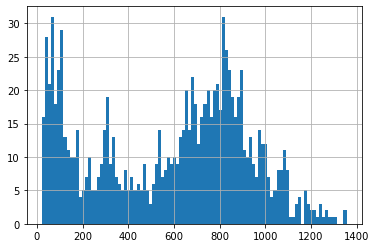

In [110]:
#check: target_value distribution in full dataframe looks same as original
df_plot[target_value].hist(bins=100)

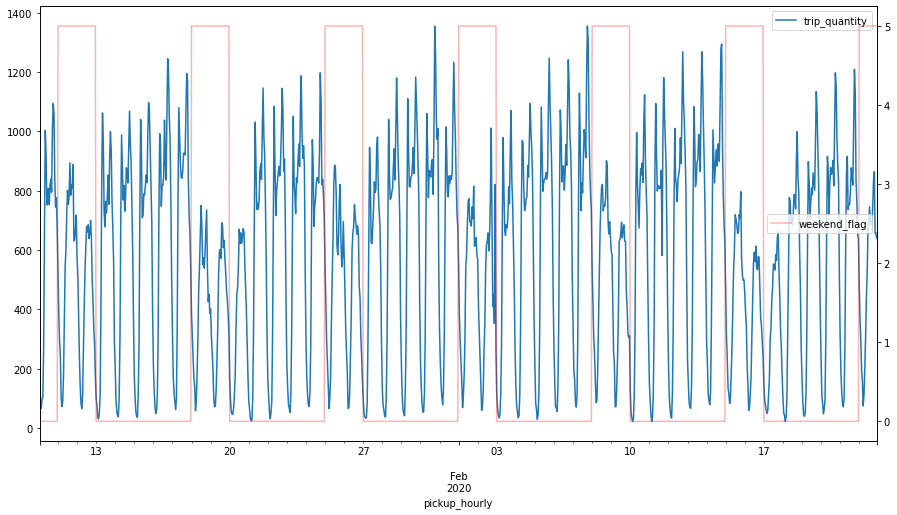

In [111]:
# EXAMPLE HOURLY RTS

# Visualize candidate RTS variables
plt.figure(figsize=(15, 8))
ax = plt.gca()
df_plot.plot(x=timestamp, y=target_value, ax=ax);
ax2 = ax.twinx()
df_plot.plot(x=timestamp, y='weekend_flag', color='red', alpha=0.3, ax=ax2);

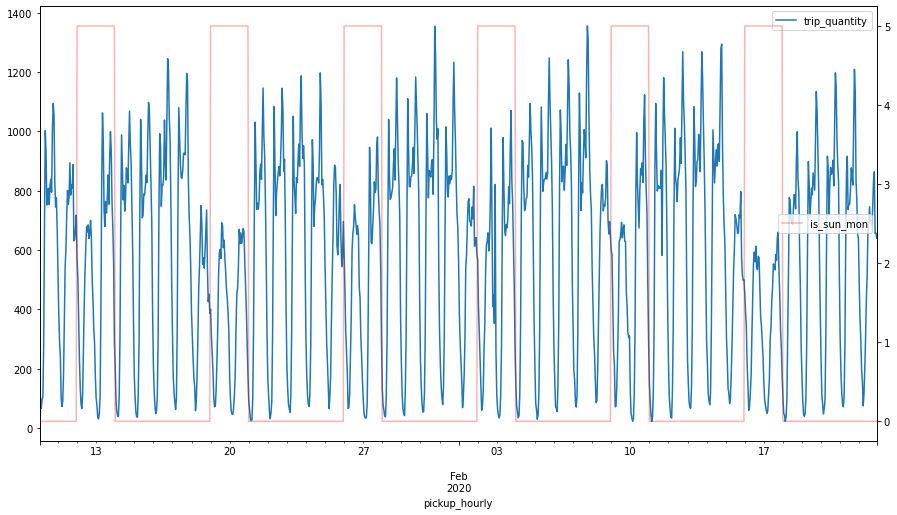

In [112]:
# EXAMPLE HOURLY RTS

# Visualize candidate RTS variables is_sun_mon
plt.figure(figsize=(15, 8))
ax = plt.gca()
df_plot.plot(x=timestamp, y=target_value, ax=ax);
ax2 = ax.twinx()
df_plot.plot(x=timestamp, y='is_sun_mon', color='red', alpha=0.3, ax=ax2);

It looks like lowest taxis rides are a combination of day and hour that seems to matter, not just day of week.

In [113]:
full_history.head(1)

,pulocationid,pickup_geolocation,pickup_hourly,trip_quantity,day_of_week,hour_of_day,day_hour_name,weekend_flag,is_sun_mon
0,1,40.68951565_-74.17678575,2019-07-01,0.00000,Monday,0,Monday_0,0,1


In [114]:
geolocation

'pickup_geolocation'

In [115]:
# EXAMPLE HOURLY RTS

# Assemble RTS - include whatever columns you finally decide
if geolocation is not None:
    rts = full_history[forecast_dims + [geolocation] + ['day_hour_name']].copy()
else:
    rts = full_history[forecast_dims + ['day_hour_name']].copy()

print(rts.shape)
print(rts.isnull().sum())
print(f"rts start: {rts[timestamp].min()}")
print(f"rts end: {rts[timestamp].max()}")
rts.sample(5)

(1522560, 4)
pickup_hourly         0
pulocationid          0
pickup_geolocation    0
day_hour_name         0
dtype: int64
rts start: 2019-07-01 00:00:00
rts end: 2020-02-29 23:00:00


,pickup_hourly,pulocationid,pickup_geolocation,day_hour_name
637986,2020-02-16 18:00:00,2,40.62572424_-73.82612577,Sunday_18
214472,2019-11-30 08:00:00,134,40.70875018_-73.8299927,Saturday_8
220663,2019-12-14 07:00:00,135,40.72940996_-73.82398551,Saturday_7
1250665,2019-11-17 01:00:00,57,40.75231604_-73.85338447,Sunday_1
653142,2019-11-08 06:00:00,201,40.57746872_-73.84724648,Friday_6


In [116]:
# Save rts to S3
local_file = "data/rts.csv"
# Save merged file locally
rts.to_csv(local_file, header=False, index=False)
print(f"Saved RTS locally to {local_file}")

key = f"{prefix}/v{DATA_VERSION}/{EXPERIMENT_NAME}.related.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)
print(f"Uploaded to s3://{bucket_name}/{key}")


Saved RTS locally to data/rts.csv
Uploaded to s3://674465894274-forecast-demo-taxi/nyc-taxi-trips/v1/nyctaxi_snap02232020_168H.related.csv


In [117]:
del all_times
del master_records

## Step 21. Classify Time Series <a class="anchor" id="Classify"></a>
Using definitions given here:  https://frepple.com/blog/demand-classification/
Original article: https://robjhyndman.com/papers/idcat.pdf <br>

Idea:  Based on demand patterns, time series can be classified into one of 4 classes:  Smooth, Intermittent, Erratic, or Lumpy.  If you have more than 1 class of time series in your data, this might suggest more than 1 model for your time series predictions.  

Rules:
<ol>
    <li><b>Smooth</b> demand (ADI < 1.32 and CV² < 0.49). Regular in time and in quantity. It is therefore easy to forecast and you won’t have trouble reaching a low forecasting error level. Suggested algorithm: <b>Traditional statistical such as Exponential Smoothing, Prophet, or ARIMA.</b></li>
    <li><b>Intermittent demand</b> (ADI >= 1.32 and CV² < 0.49). The demand history shows very little variation in demand quantity but a high variation in the interval between two demands. Though specific forecasting methods tackle intermittent demands, the forecast error margin is considerably higher. Suggested algorithm: <b>Croston smoothing or some newer research approach coupled with adjusted error metric over longer time period.</b></li>
    <li><b>Erratic</b> demand (ADI < 1.32 and CV² >= 0.49). The demand has regular occurrences in time with high quantity variations. Your forecast accuracy remains shaky. Suggested algorithm: <b>Deep Learning</b></li>
<li><b>Lumpy</b> demand (ADI >= 1.32 and CV² >= 0.49). The demand is characterized by a large variation in quantity and in time. It is actually impossible to produce a reliable forecast, no matter which forecasting tools you use. This particular type of demand pattern is unforecastable. Suggested algorithm: <b>bootstrap</b></li>
    </ol>

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.

THIS IS JUST A TEST TO CHECK COLOR CHOICES...


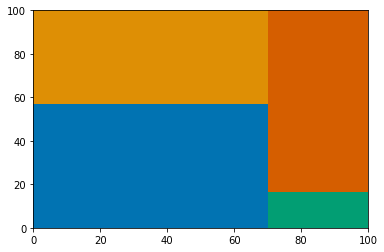

In [118]:
!pip install squarify
import squarify

# SCRATCH - choose 4 colors
print("\nTHIS IS JUST A TEST TO CHECK COLOR CHOICES...")
colors = colorblind6[0:4]
sizes = [40, 30, 5, 25]
squarify.plot(sizes, color=colors)
plt.show();

In [119]:
%%time
# CPU times: user 2.54 s, sys: 209 ms, total: 2.75 s
# Wall time: 2.84 s

full_history = local_util.analysis.classify_timeseries_set(
    full_history,
    time_col=timestamp,
    item_id_col=item_id,
    other_dimension_cols=[d for d in dims_except_timestamp if d != item_id],
    target_col=target_value,
    num_dask_partitions=num_partitions,
    # In case pandas-based method is too slow and you have sufficient memory available to
    # parallelize, set the below `True` to use Dask instead:
    use_dask_if_available=False,
)
full_history.sample(3)

Aggregating with Pandas
CPU times: user 3.03 s, sys: 397 ms, total: 3.43 s
Wall time: 3.43 s


,pulocationid,pickup_geolocation,pickup_hourly,trip_quantity,day_of_week,hour_of_day,day_hour_name,weekend_flag,is_sun_mon,ADI,CV_square,ts_type
1179741,46,40.8474999_-73.78648631,2019-10-20 21:00:00,0.00000,Sunday,21,Sunday_21,1,1,1.00000,0.00796,smooth
421031,166,40.80957023_-73.96181526,2020-02-04 23:00:00,23.00000,Tuesday,23,Tuesday_23,0,0,1.00000,0.45384,smooth
601754,194,40.79143296_-73.92102903,2020-01-02 02:00:00,0.00000,Thursday,2,Thursday_2,0,0,1.00000,0.36821,smooth


,Count,Percentage
smooth,213,81.92308
erratic,43,16.53846
intermittent,4,1.53846


<AxesSubplot:>

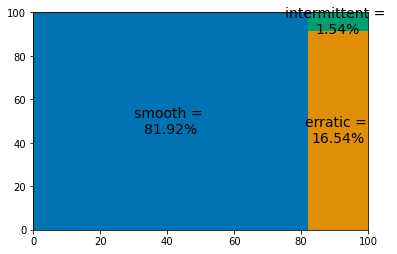

In [120]:
# Count the *series* (not data points) in each ts_type:
type_counts = full_history.groupby(
    dims_except_timestamp + ([geolocation] if geolocation else [])
)["ts_type"].first().value_counts()

# Plot the number of timeseries by type:
display(pd.DataFrame({ "Count": type_counts, "Percentage": 100 * type_counts / type_counts.sum() }))
squarify.plot(
    label=[f"{i} = \n{v / sum(type_counts):.2%}" for i, v in type_counts.iteritems()],
    sizes=type_counts,
    color=colors,
    text_kwargs={ "fontsize": 14 },
)

In [121]:
# Restore previous full_history:
# full_history.drop(["ADI", "CV_square", "ts_type"], inplace=True, axis=1)
# full_history.head(1)

SHOWING SAMPLE ERRATIC SERIES


,pulocationid
960384,25
251808,140
1399584,80
1141920,40
117120,12


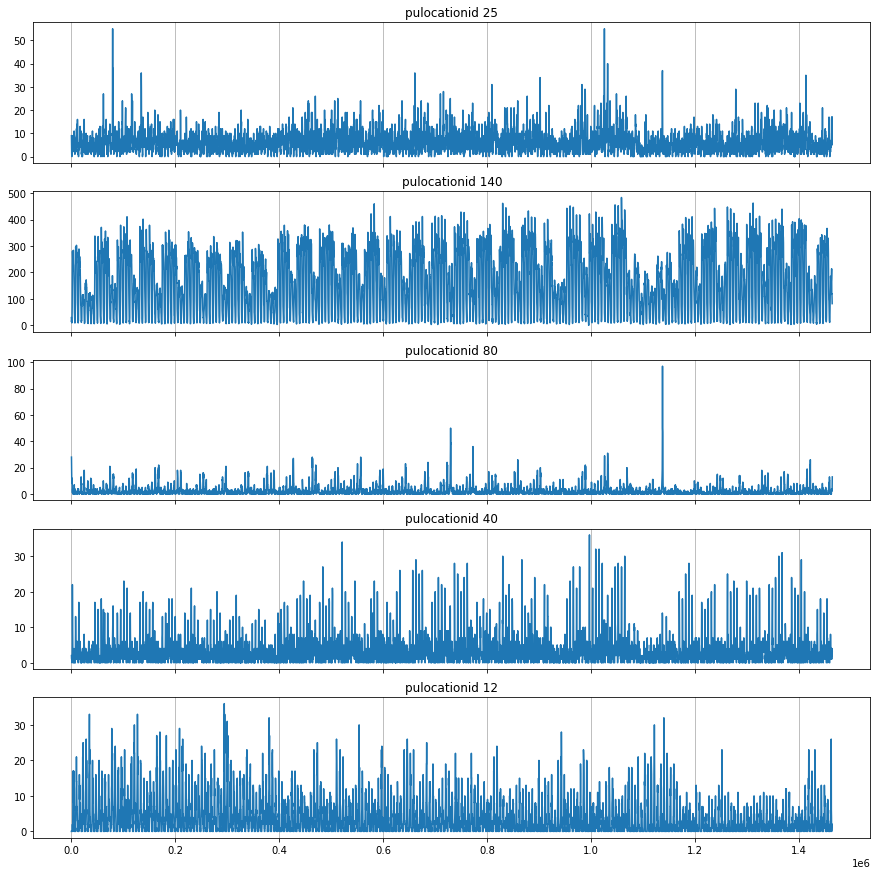

In [122]:
n_sample = min(type_counts.get("erratic", 0), 5)
if n_sample > 0:
    print("SHOWING SAMPLE ERRATIC SERIES")
    erratic_series = full_history.loc[
        full_history["ts_type"] == "erratic"
    ][dims_except_timestamp].drop_duplicates().sample(n_sample)

    display(erratic_series)
    local_util.plotting.make_plots(
        tts,
        erratic_series,
        target_value_col=target_value,
    )
else:
    print("No erratic time series found.")

SHOWING SAMPLE SMOOTH SERIES


,pulocationid
1054080,27
650016,201
1510848,98
614880,197
825696,229


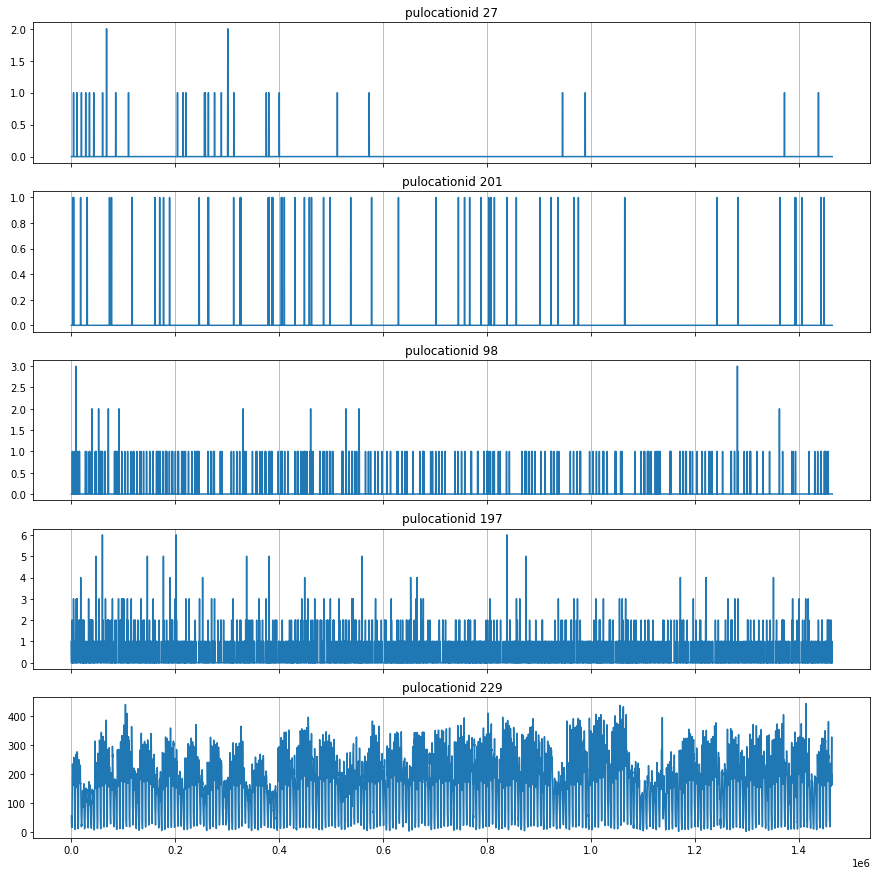

In [123]:
n_sample = min(type_counts.get("smooth", 0), 5)
if n_sample > 0:
    print("SHOWING SAMPLE SMOOTH SERIES")
    smooth_series = full_history.loc[
        full_history["ts_type"] == "smooth"
    ][dims_except_timestamp].drop_duplicates().sample(n_sample)

    display(smooth_series)
    local_util.plotting.make_plots(
        tts,
        smooth_series,
        target_value_col=target_value,
    )
else:
    print("No smooth time series found.")

SHOWING SAMPLE INTERMITTENT SERIES


,pulocationid
667584,204
1077504,30
480192,176
626592,199


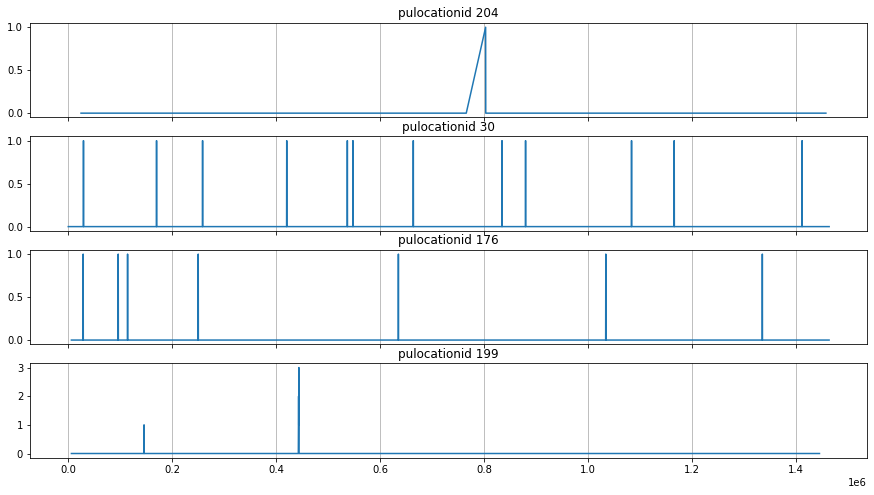

In [124]:
n_sample = min(type_counts.get("intermittent", 0), 5)
if n_sample > 0:
    print("SHOWING SAMPLE INTERMITTENT SERIES")
    intermittent_series = full_history.loc[
        full_history["ts_type"] == "intermittent"
    ][dims_except_timestamp].drop_duplicates().sample(n_sample)

    display(intermittent_series)
    local_util.plotting.make_plots(
        tts,
        intermittent_series,
        target_value_col=target_value,
    )
else:
    print("No intermittent time series found.")

In [125]:
n_sample = min(type_counts.get("lumpy", 0), 5)
if n_sample > 0:
    print("SHOWING LUMPY INTERMITTENT SERIES")
    lumpy_series = full_history.loc[
        full_history["ts_type"] == "lumpy"
    ][dims_except_timestamp].drop_duplicates().sample(n_sample)

    display(lumpy_series)
    local_util.plotting.make_plots(
        tts,
        lumpy_series,
        target_value_col=target_value,
    )
else:
    print("No lumpy time series found.")

No lumpy time series found.


It looks like only "erratic" time series are worth predicting.  All the rest look either suspiciously fake or too few data points.

## Step 22. Optional - Assemble and save TTS_smooth, TTS_erratic, TTS_intermittent, TTS_lumpy <a class="anchor" id="TTS_classes"></a>



In [126]:
for t in type_counts.index:
    print(f"\n#### Subset '{t}' ####")

    subset = full_history.loc[
        full_history["ts_type"] == t
    ][dims_except_timestamp].drop_duplicates()
    num_subset_ts = len(subset)

    tts_subset = local_util.dataprep.select_by_df(tts, subset)
    num_subset_items = tts_subset[item_id].nunique()
    print(f"Selected {tts_subset.shape} from {tts.shape}")
    print(f"{num_subset_ts} time-series, {num_subset_items} unique item IDs")

    # Save file locally and upload to S3:
    local_file = f"data/tts_{t}.csv"
    tts_subset.to_csv(local_file, header=False, index=False)
    print(f"Saved {t} subset to {local_file}")

    key = f"{prefix}/v{DATA_VERSION}/tts_{t}_{EXPERIMENT_NAME}.csv"
    boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)
    print(f"Uploaded to s3://{bucket_name}/{key}")


#### Subset 'smooth' ####
Selected (1209912, 4) from (1464240, 4)
213 time-series, 213 unique item IDs
Saved smooth subset to data/tts_smooth.csv
Uploaded to s3://674465894274-forecast-demo-taxi/nyc-taxi-trips/v1/tts_smooth_nyctaxi_snap02232020_168H.csv

#### Subset 'erratic' ####
Selected (244584, 4) from (1464240, 4)
43 time-series, 43 unique item IDs
Saved erratic subset to data/tts_erratic.csv
Uploaded to s3://674465894274-forecast-demo-taxi/nyc-taxi-trips/v1/tts_erratic_nyctaxi_snap02232020_168H.csv

#### Subset 'intermittent' ####
Selected (9744, 4) from (1464240, 4)
4 time-series, 4 unique item IDs
Saved intermittent subset to data/tts_intermittent.csv
Uploaded to s3://674465894274-forecast-demo-taxi/nyc-taxi-trips/v1/tts_intermittent_nyctaxi_snap02232020_168H.csv


## Step 23. Assemble and save metadata (if any) <a class="anchor" id="IM"></a>

In [127]:
# Identify metadata columns
im = df[dims_except_timestamp + ['pickup_borough']].copy()
im = im.groupby(dims_except_timestamp).first()
im.reset_index(inplace=True)
# check nulls
display(im.isnull().sum())
im.sample(5)

pulocationid      0
pickup_borough    0
dtype: int64

,pulocationid,pickup_borough
18,118,Staten Island
51,148,Manhattan
178,262,Manhattan
17,117,Queens
82,176,Staten Island


In [128]:
# Additional metadata created by binning just item target_value is sometimes useful.

# aggregate sales by item 
synthetic = df.copy()
synthetic = (synthetic.groupby(item_id).agg({ target_value: ["max"] }))

synthetic = synthetic.reset_index()
synthetic.sample(5)

#bin data into 4 categories
cat_scales = ["Cat_{}".format(i) for i in range(1,5)]
synthetic['item_cat_by_max'] = list(pd.cut(synthetic[target_value]['max'].values, 4, labels=cat_scales))

synthetic.drop(target_value, axis=1, inplace=True)
synthetic.columns = synthetic.columns.get_level_values(0)

print(synthetic.shape)
print(synthetic.dtypes)
print(synthetic.columns)
display(synthetic.sample(5))
print(synthetic.item_cat_by_max.value_counts(dropna=False))

# merge synthetic features
im = im.merge(synthetic, how="left", on=[item_id])
print(im.shape, synthetic.shape)
im.head()

(260, 2)
pulocationid       object
item_cat_by_max    object
dtype: object
Index(['pulocationid', 'item_cat_by_max'], dtype='object')


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,pulocationid,item_cat_by_max
200,45,Cat_1
53,15,Cat_1
205,5,Cat_1
107,199,Cat_1
241,82,Cat_1


Cat_1    234
Cat_2     20
Cat_3      4
Cat_4      2
Name: item_cat_by_max, dtype: int64
(260, 3) (260, 2)


,pulocationid,pickup_borough,item_cat_by_max
0,1,EWR,Cat_1
1,10,Queens,Cat_1
2,100,Manhattan,Cat_1
3,101,Queens,Cat_1
4,102,Queens,Cat_1


In [129]:
# check metadata so far

print(im.shape)
if im.shape[0] < 50:
    display(im)
else:
    display(im.head())

# check cardinality of metadata columns
im.describe()

(260, 3)


,pulocationid,pickup_borough,item_cat_by_max
0,1,EWR,Cat_1
1,10,Queens,Cat_1
2,100,Manhattan,Cat_1
3,101,Queens,Cat_1
4,102,Queens,Cat_1


,pulocationid,pickup_borough,item_cat_by_max
count,260,260,260
unique,260,6,4
top,141,Queens,Cat_1
freq,1,69,234


In [130]:
sparse.head()

pulocationid
99     4872
187    4872
30     4056
176    3240
199    1632
Name: trip_quantity, dtype: int64

In [131]:
# merge in sparse or not column
im['is_sparse'] = 0

im.loc[(im[item_id].isin(list(sparse.index.to_frame()[item_id].unique()))), 'is_sparse'] = 1
print(im.is_sparse.value_counts(dropna=False))
im.sample(5)

0    254
1      6
Name: is_sparse, dtype: int64


,pulocationid,pickup_borough,item_cat_by_max,is_sparse
179,263,Manhattan,Cat_1,0
160,246,Manhattan,Cat_2,0
90,183,Bronx,Cat_1,0
51,148,Manhattan,Cat_4,0
168,253,Queens,Cat_1,0


In [132]:
# merge in top-moving or not column
im['top_moving'] = 0

im.loc[(im[item_id].isin(list(top_movers.index.to_frame()[item_id].unique()))), 'top_moving'] = 1
print(im.top_moving.value_counts(dropna=False))
im.sample(5)

0    213
1     47
Name: top_moving, dtype: int64


,pulocationid,pickup_borough,item_cat_by_max,is_sparse,top_moving
78,172,Staten Island,Cat_1,0,0
12,112,Brooklyn,Cat_1,0,0
137,225,Brooklyn,Cat_1,0,0
96,189,Brooklyn,Cat_1,0,0
30,129,Queens,Cat_1,0,0


In [133]:
# merge in time series categories column
categories_df = full_history.groupby([item_id])[item_id, 'ts_type'].first()
categories_df.reset_index(inplace=True, drop=True)
# categories_df.head(2)

im = im.merge(categories_df, how="left", on=[item_id])
print(im.ts_type.value_counts(dropna=False))
im.sample(5)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  from ipykernel import kernelapp as app


smooth          213
erratic          43
intermittent      4
Name: ts_type, dtype: int64


,pulocationid,pickup_borough,item_cat_by_max,is_sparse,top_moving,ts_type
47,144,Manhattan,Cat_2,0,1,erratic
175,26,Brooklyn,Cat_1,0,0,smooth
69,164,Manhattan,Cat_2,0,1,smooth
193,39,Brooklyn,Cat_1,0,0,smooth
68,163,Manhattan,Cat_2,0,1,smooth


In [134]:
# Assemble metadata just columns you want

im = im.iloc[:, 0:3].groupby(item_id).max()
im.reset_index(inplace=True)
print(im.shape)
print("checking nulls..")
print(im.isnull().sum())
im.sample(5)

(260, 3)
checking nulls..
pulocationid       0
pickup_borough     0
item_cat_by_max    0
dtype: int64


,pulocationid,pickup_borough,item_cat_by_max
170,255,Brooklyn,Cat_1
83,177,Brooklyn,Cat_1
68,163,Manhattan,Cat_2
48,145,Queens,Cat_1
233,75,Manhattan,Cat_1


In [135]:
# Save im to S3
local_file = "data/metadata.csv"
# Save merged file locally
im.to_csv(local_file, header=False, index=False)
print(f"Saved metadata to {local_file}")

key = f"{prefix}/v{DATA_VERSION}/{EXPERIMENT_NAME}.metadata.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)
print(f"Uploaded to s3://{bucket_name}/{key}")

Saved metadata to data/metadata.csv
Uploaded to s3://674465894274-forecast-demo-taxi/nyc-taxi-trips/v1/nyctaxi_snap02232020_168H.metadata.csv
